In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import minmax_scale
import torch
from torch.autograd import Variable
from sklearn.model_selection import train_test_split


def get_dataset():
    col_list = ['unit', 'time', 'os_1', 'os_2', 'os_3', 'sm_1', 'sm_2', 'sm_3', 'sm_4', 'sm_5', 'sm_6', 'sm_7', 'sm_8', 'sm_9', 'sm_10', 'sm_11', 'sm_12', 'sm_13', 'sm_14', 'sm_15', 'sm_16', 'sm_17', 'sm_18', 'sm_19', 'sm_20', 'sm_21']
    new_col_list = ['unit', 'time', 'os_1', 'os_2', 'sm_2', 'sm_3', 'sm_4', 'sm_6', 'sm_7', 'sm_8', 'sm_9', 'sm_11', 'sm_12', 'sm_13', 'sm_14', 'sm_15', 'sm_17', 'sm_20', 'sm_21']
    device = torch.device('cpu')


    df_train = pd.read_csv(r"/kaggle/input/dataset/dataset/train_FD001.txt", sep = ' ', header = None)
    df_test = pd.read_csv(r"/kaggle/input/dataset/dataset/test_FD001.txt", sep = ' ', header = None)
    df_RUL = pd.read_csv(r"/kaggle/input/dataset/dataset/RUL_FD001.txt", header = None)

    df_train = df_train[list(range(26))]
    df_train.columns = col_list
    df_train = df_train[new_col_list]

    df_test = df_test[list(range(26))]
    df_test.columns = col_list
    df_test = df_test[new_col_list]

    scale_col_list = new_col_list[2:]
    df_train[scale_col_list] = minmax_scale(df_train[scale_col_list])
    df_test[scale_col_list] = minmax_scale(df_test[scale_col_list])

   

    seq_selected = min(df_test.groupby('unit').max()['time'])
    max_list = list(df_train.groupby('unit').max()['time']) 


    i = 0
    X_train = Variable(torch.Tensor([]).float()).to(device)
    for item in max_list:
        temp_list = Variable(torch.Tensor([]).float()).to(device)
        for j in range(item - seq_selected):
            zero_list = Variable(torch.Tensor(df_train.values[i+j:i+j+seq_selected, 2:]).float()).to(device)
            # temp_list = torch.cat((temp_list, zero_list.view(1, seq_selected, 18)), dim=0)
            temp_list = torch.cat((temp_list, zero_list.view(1, seq_selected, 17)), dim=0)
        i += item
        X_train = torch.cat((X_train, temp_list), dim=0)

    print("The shape of input data for training model, X_train is", X_train.shape)

    y_train = []
    for item in max_list:
        y_train.extend(list(range(item-seq_selected))[::-1])
    y_train.extend(i if i<125 else 125 for i in list(range(item-seq_selected))[::-1])
    y_train = Variable(torch.Tensor(y_train).float()).to(device)

    print(f"Shape of X_train: {X_train.shape}")
    print(f"Shape of y_train before view: {y_train.shape}")
    y_train = y_train[:X_train.shape[0]]
    y_train = y_train.view(X_train.shape[0], 1)


    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    print("The shape of input data for training model, X_train is", X_train.shape)
    print("The shape of input data for training model, y_train is", y_train.shape)
    print("The shape of input data for validation model, X_val is", X_val.shape)
    print("The shape of input data for validation model, y_val is", y_val.shape)

    max_list_test = list(df_test.groupby('unit').max()['time'])
    i = 0
    input_size = 17
    X_test = Variable(torch.Tensor([]).float()).to(device)
    for item in max_list_test:
        temp_list = Variable(torch.Tensor([]).float()).to(device)
        zero_list = Variable(torch.Tensor(df_test.values[i + item - seq_selected : i + item, 2:]).float()).to(device)
        # temp_list = torch.cat((temp_list, zero_list.view(1, seq_selected, 18)), dim=0)
        temp_list = torch.cat((temp_list, zero_list.view(1, seq_selected, input_size)), dim=0)
        i += item
        X_test = torch.cat((X_test, temp_list), dim=0)
    print("The shape of input data for testing model, X_test is", X_test.shape)
    y_test = df_RUL.values
    # clip them to 125
    y_test = np.clip(y_test, 0, 125)
    y_test = Variable(torch.Tensor(y_test).float()).to(device)
    print("The shape of input data for testing model, y_test is", y_test.shape)
    return X_train, y_train, X_val, y_val, X_test, y_test


X_train, y_train, X_val, y_val, X_test, y_test = get_dataset()

The shape of input data for training model, X_train is torch.Size([17531, 31, 17])
Shape of X_train: torch.Size([17531, 31, 17])
Shape of y_train before view: torch.Size([17700])
The shape of input data for training model, X_train is torch.Size([14024, 31, 17])
The shape of input data for training model, y_train is torch.Size([14024, 1])
The shape of input data for validation model, X_val is torch.Size([3507, 31, 17])
The shape of input data for validation model, y_val is torch.Size([3507, 1])
The shape of input data for testing model, X_test is torch.Size([100, 31, 17])
The shape of input data for testing model, y_test is torch.Size([100, 1])


In [5]:
device = torch.device("cuda")
import matplotlib.pyplot as plt

In [28]:
import torch.nn.functional as F
import torch
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            torch.nn.Conv2d(  
                in_channels=1,  
                out_channels=20,  
                kernel_size=3,  
                stride=1, 
                padding=2  
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.fc = nn.Linear(20*16*9, 1) 

    def forward(self, x):
        x=torch.unsqueeze(x, dim=1)
        x = self.conv1(x)
        x = x.view(x.size(0), -1)  
        x = self.fc(x)
        return x
torch.manual_seed(114514)
model=CNN().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0225433835001291)
savepth="cnn"

In [36]:
import optuna
def objective(trial):
    # set random seed
    torch.manual_seed(114514)
    #hidden_size = trial.suggest_int('hidden_size', 50, 200)
    #hidden_size2 = trial.suggest_int('hidden_size2', 30, 200)
    learning_rate = trial.suggest_loguniform('learning_rate',2e-3, 5e-2)
    num_epochs = trial.suggest_int('num_epochs', 30,150)
    model=CNN().to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):
        model.train()
        for i in range(0, len(X_train), batch_size):
            optimizer.zero_grad()
            indices = range(i, min(i+batch_size, len(X_train)))
            X_batch = X_train[indices].to(device)
            out = model(X_batch)
            loss = criterion(out, y_train[indices].to(device))        
            loss.backward()
            optimizer.step()
        if epoch%10==0:
            val_loss = criterion(model(X_val.to(device)), y_val.to(device)).item()
            print(f'Epoch {epoch}, Loss: {loss.item()}',f'Validation Loss: {val_loss}')
    model.eval()   
    test_predictions = model(X_test.to(device))
    # clip test predictions between 0 and 125
    test_predictions = torch.clamp(test_predictions, 0, 125)

    test_loss = criterion(test_predictions, y_test.to(device)).item()

    return test_loss
    # evaluate on test set
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=200)
print('Best trial:', study.best_params)

[I 2024-11-24 01:24:24,801] A new study created in memory with name: no-name-895a0dab-04db-43e8-a4b5-6e40b91ba566
/tmp/ipykernel_30/2670316111.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate',2e-3, 5e-2)


Epoch 0, Loss: 5021.81640625 Validation Loss: 3732.749755859375
Epoch 10, Loss: 1936.1727294921875 Validation Loss: 1542.870361328125
Epoch 20, Loss: 1838.298095703125 Validation Loss: 1433.7401123046875
Epoch 30, Loss: 1705.308349609375 Validation Loss: 1307.300537109375
Epoch 40, Loss: 1580.823974609375 Validation Loss: 1184.109375
Epoch 50, Loss: 1495.2021484375 Validation Loss: 1098.045166015625
Epoch 60, Loss: 1433.2213134765625 Validation Loss: 1049.7144775390625
Epoch 70, Loss: 1387.1007080078125 Validation Loss: 1022.1168823242188
Epoch 80, Loss: 1352.445556640625 Validation Loss: 1004.4889526367188
Epoch 90, Loss: 1323.6807861328125 Validation Loss: 992.0208129882812
Epoch 100, Loss: 1301.676025390625 Validation Loss: 983.1368408203125


[I 2024-11-24 01:24:35,594] Trial 0 finished with value: 575.519287109375 and parameters: {'learning_rate': 0.002069442809379894, 'num_epochs': 111}. Best is trial 0 with value: 575.519287109375.


Epoch 110, Loss: 1283.394775390625 Validation Loss: 976.2359619140625
Epoch 0, Loss: 3082.0927734375 Validation Loss: 2233.939697265625
Epoch 10, Loss: 1599.162109375 Validation Loss: 1243.594482421875
Epoch 20, Loss: 1458.4068603515625 Validation Loss: 998.0507202148438
Epoch 30, Loss: 1280.4739990234375 Validation Loss: 945.39892578125
Epoch 40, Loss: 1186.4913330078125 Validation Loss: 923.1409912109375
Epoch 50, Loss: 1128.7398681640625 Validation Loss: 907.7622680664062


[I 2024-11-24 01:24:41,113] Trial 1 finished with value: 365.1177978515625 and parameters: {'learning_rate': 0.010512443540279276, 'num_epochs': 57}. Best is trial 1 with value: 365.1177978515625.


Epoch 0, Loss: 3319.790283203125 Validation Loss: 2437.317138671875
Epoch 10, Loss: 1607.36328125 Validation Loss: 1283.244873046875
Epoch 20, Loss: 1489.833984375 Validation Loss: 1015.9541015625
Epoch 30, Loss: 1322.3896484375 Validation Loss: 949.3511352539062
Epoch 40, Loss: 1235.0482177734375 Validation Loss: 927.86474609375


[I 2024-11-24 01:24:45,630] Trial 2 finished with value: 371.7570495605469 and parameters: {'learning_rate': 0.009220582968141499, 'num_epochs': 47}. Best is trial 1 with value: 365.1177978515625.


Epoch 0, Loss: 2348.271484375 Validation Loss: 1756.8675537109375
Epoch 10, Loss: 1747.5728759765625 Validation Loss: 1082.37548828125
Epoch 20, Loss: 1361.71484375 Validation Loss: 967.8728637695312
Epoch 30, Loss: 1240.1785888671875 Validation Loss: 935.4112548828125
Epoch 40, Loss: 1164.4976806640625 Validation Loss: 917.3935546875
Epoch 50, Loss: 1106.417724609375 Validation Loss: 908.142578125
Epoch 60, Loss: 1066.619873046875 Validation Loss: 901.8911743164062
Epoch 70, Loss: 1027.10107421875 Validation Loss: 898.0664672851562
Epoch 80, Loss: 998.6764526367188 Validation Loss: 893.6093139648438
Epoch 90, Loss: 970.3809204101562 Validation Loss: 883.4061889648438
Epoch 100, Loss: 930.1448974609375 Validation Loss: 873.2933349609375
Epoch 110, Loss: 893.96435546875 Validation Loss: 866.8535766601562
Epoch 120, Loss: 868.8744506835938 Validation Loss: 853.8229370117188


[I 2024-11-24 01:24:58,149] Trial 3 finished with value: 537.3176879882812 and parameters: {'learning_rate': 0.018436950736856732, 'num_epochs': 128}. Best is trial 1 with value: 365.1177978515625.


Epoch 0, Loss: 4110.7685546875 Validation Loss: 2980.085205078125
Epoch 10, Loss: 1751.223388671875 Validation Loss: 1359.4295654296875
Epoch 20, Loss: 1474.3878173828125 Validation Loss: 1113.4791259765625
Epoch 30, Loss: 1418.248291015625 Validation Loss: 1005.7835693359375
Epoch 40, Loss: 1352.0843505859375 Validation Loss: 966.574951171875


[I 2024-11-24 01:25:02,585] Trial 4 finished with value: 345.7595520019531 and parameters: {'learning_rate': 0.0061238984145576035, 'num_epochs': 46}. Best is trial 4 with value: 345.7595520019531.


Epoch 0, Loss: 2152.687744140625 Validation Loss: 1737.413330078125
Epoch 10, Loss: 1698.929931640625 Validation Loss: 1060.39990234375
Epoch 20, Loss: 1332.4913330078125 Validation Loss: 960.458740234375
Epoch 30, Loss: 1225.991943359375 Validation Loss: 928.4549560546875
Epoch 40, Loss: 1149.4075927734375 Validation Loss: 911.472900390625
Epoch 50, Loss: 1096.853271484375 Validation Loss: 903.0770874023438
Epoch 60, Loss: 1051.2139892578125 Validation Loss: 899.900634765625
Epoch 70, Loss: 1012.8673706054688 Validation Loss: 890.6610717773438
Epoch 80, Loss: 973.084716796875 Validation Loss: 885.7357788085938
Epoch 90, Loss: 935.0685424804688 Validation Loss: 878.9572143554688
Epoch 100, Loss: 893.0469360351562 Validation Loss: 883.5077514648438
Epoch 110, Loss: 864.8685913085938 Validation Loss: 880.5242919921875
Epoch 120, Loss: 843.43310546875 Validation Loss: 880.5260620117188
Epoch 130, Loss: 821.4453125 Validation Loss: 878.3980712890625


[I 2024-11-24 01:25:16,724] Trial 5 finished with value: 830.2695922851562 and parameters: {'learning_rate': 0.020075772154251482, 'num_epochs': 143}. Best is trial 4 with value: 345.7595520019531.


Epoch 140, Loss: 808.326171875 Validation Loss: 877.7925415039062
Epoch 0, Loss: 4351.0556640625 Validation Loss: 3206.390625
Epoch 10, Loss: 1788.6949462890625 Validation Loss: 1416.7047119140625
Epoch 20, Loss: 1547.675537109375 Validation Loss: 1178.5863037109375
Epoch 30, Loss: 1394.6202392578125 Validation Loss: 1055.6048583984375
Epoch 40, Loss: 1320.190185546875 Validation Loss: 1008.4287109375
Epoch 50, Loss: 1277.263916015625 Validation Loss: 983.5816650390625
Epoch 60, Loss: 1246.866943359375 Validation Loss: 967.0095825195312
Epoch 70, Loss: 1218.058349609375 Validation Loss: 955.0490112304688
Epoch 80, Loss: 1190.4437255859375 Validation Loss: 944.941650390625
Epoch 90, Loss: 1163.3304443359375 Validation Loss: 935.9556884765625
Epoch 100, Loss: 1136.3487548828125 Validation Loss: 929.2919921875
Epoch 110, Loss: 1110.3555908203125 Validation Loss: 923.62744140625
Epoch 120, Loss: 1085.8153076171875 Validation Loss: 918.4755859375
Epoch 130, Loss: 1063.7060546875 Validation 

[I 2024-11-24 01:25:30,165] Trial 6 finished with value: 556.5211791992188 and parameters: {'learning_rate': 0.004924284297794122, 'num_epochs': 135}. Best is trial 4 with value: 345.7595520019531.


Epoch 0, Loss: 4231.31005859375 Validation Loss: 3092.07568359375
Epoch 10, Loss: 1774.64208984375 Validation Loss: 1391.0428466796875
Epoch 20, Loss: 1508.5274658203125 Validation Loss: 1150.6280517578125
Epoch 30, Loss: 1368.8671875 Validation Loss: 1029.5948486328125
Epoch 40, Loss: 1289.373046875 Validation Loss: 995.4757690429688
Epoch 50, Loss: 1250.9742431640625 Validation Loss: 976.74755859375
Epoch 60, Loss: 1218.9173583984375 Validation Loss: 961.836669921875


[I 2024-11-24 01:25:36,404] Trial 7 finished with value: 452.924560546875 and parameters: {'learning_rate': 0.005507357037714205, 'num_epochs': 64}. Best is trial 4 with value: 345.7595520019531.


Epoch 0, Loss: 2072.6953125 Validation Loss: 1699.7890625
Epoch 10, Loss: 1497.180908203125 Validation Loss: 1018.9562377929688
Epoch 20, Loss: 1223.5487060546875 Validation Loss: 936.3668823242188
Epoch 30, Loss: 1108.493896484375 Validation Loss: 917.9295043945312
Epoch 40, Loss: 1050.7672119140625 Validation Loss: 906.1005249023438
Epoch 50, Loss: 1007.1399536132812 Validation Loss: 885.8390502929688
Epoch 60, Loss: 951.3237915039062 Validation Loss: 867.968505859375
Epoch 70, Loss: 907.3259887695312 Validation Loss: 850.730224609375
Epoch 80, Loss: 880.5849609375 Validation Loss: 830.9188842773438
Epoch 90, Loss: 840.4107666015625 Validation Loss: 823.1328735351562
Epoch 100, Loss: 813.9862060546875 Validation Loss: 825.958740234375
Epoch 110, Loss: 778.091064453125 Validation Loss: 820.7781372070312


[I 2024-11-24 01:25:48,125] Trial 8 finished with value: 650.05810546875 and parameters: {'learning_rate': 0.02840627002404792, 'num_epochs': 121}. Best is trial 4 with value: 345.7595520019531.


Epoch 120, Loss: 747.5628051757812 Validation Loss: 818.9884643554688
Epoch 0, Loss: 2140.79052734375 Validation Loss: 1647.3856201171875
Epoch 10, Loss: 1421.43212890625 Validation Loss: 995.36669921875
Epoch 20, Loss: 1215.015625 Validation Loss: 939.8068237304688
Epoch 30, Loss: 1101.705322265625 Validation Loss: 925.0042724609375
Epoch 40, Loss: 1053.537109375 Validation Loss: 913.0444946289062
Epoch 50, Loss: 1020.6298217773438 Validation Loss: 902.5423583984375
Epoch 60, Loss: 963.3513793945312 Validation Loss: 904.5360717773438
Epoch 70, Loss: 906.6683349609375 Validation Loss: 910.2479248046875
Epoch 80, Loss: 868.309814453125 Validation Loss: 918.3859252929688
Epoch 90, Loss: 837.2848510742188 Validation Loss: 911.9967041015625
Epoch 100, Loss: 800.9675903320312 Validation Loss: 901.9216918945312
Epoch 110, Loss: 779.1235961914062 Validation Loss: 891.4426879882812
Epoch 120, Loss: 789.7815551757812 Validation Loss: 883.1435546875
Epoch 130, Loss: 783.6712036132812 Validation 

[I 2024-11-24 01:26:02,388] Trial 9 finished with value: 487.1681823730469 and parameters: {'learning_rate': 0.03848040224741064, 'num_epochs': 148}. Best is trial 4 with value: 345.7595520019531.


Epoch 0, Loss: 5044.125 Validation Loss: 3761.272705078125
Epoch 10, Loss: 1939.329345703125 Validation Loss: 1546.781494140625
Epoch 20, Loss: 1847.9935302734375 Validation Loss: 1440.5745849609375
Epoch 30, Loss: 1720.9482421875 Validation Loss: 1320.271728515625
Epoch 40, Loss: 1595.494384765625 Validation Loss: 1196.7232666015625
Epoch 50, Loss: 1506.39501953125 Validation Loss: 1108.1591796875
Epoch 60, Loss: 1441.14697265625 Validation Loss: 1056.2957763671875
Epoch 70, Loss: 1394.1112060546875 Validation Loss: 1026.8565673828125


[I 2024-11-24 01:26:10,298] Trial 10 finished with value: 419.3621826171875 and parameters: {'learning_rate': 0.002001580415311047, 'num_epochs': 82}. Best is trial 4 with value: 345.7595520019531.


Epoch 80, Loss: 1358.520751953125 Validation Loss: 1008.0611572265625
Epoch 0, Loss: 3320.0791015625 Validation Loss: 2437.552734375
Epoch 10, Loss: 1606.9893798828125 Validation Loss: 1283.1357421875
Epoch 20, Loss: 1489.9796142578125 Validation Loss: 1015.9894409179688


[I 2024-11-24 01:26:13,178] Trial 11 finished with value: 314.91650390625 and parameters: {'learning_rate': 0.00921965200163453, 'num_epochs': 30}. Best is trial 11 with value: 314.91650390625.


Epoch 0, Loss: 4295.890625 Validation Loss: 3153.1015625
Epoch 10, Loss: 1780.0543212890625 Validation Loss: 1404.655517578125
Epoch 20, Loss: 1528.173095703125 Validation Loss: 1165.3577880859375


[I 2024-11-24 01:26:16,168] Trial 12 finished with value: 366.4418640136719 and parameters: {'learning_rate': 0.005191020855434857, 'num_epochs': 31}. Best is trial 11 with value: 314.91650390625.


Epoch 30, Loss: 1379.4649658203125 Validation Loss: 1044.4810791015625
Epoch 0, Loss: 3345.161865234375 Validation Loss: 2457.73583984375
Epoch 10, Loss: 1611.4346923828125 Validation Loss: 1286.7139892578125
Epoch 20, Loss: 1492.76416015625 Validation Loss: 1017.922119140625


[I 2024-11-24 01:26:19,405] Trial 13 finished with value: 324.2574768066406 and parameters: {'learning_rate': 0.009128847989895831, 'num_epochs': 33}. Best is trial 11 with value: 314.91650390625.


Epoch 30, Loss: 1324.1304931640625 Validation Loss: 949.8425903320312
Epoch 0, Loss: 3039.59375 Validation Loss: 2192.17529296875
Epoch 10, Loss: 1746.417724609375 Validation Loss: 1244.249755859375
Epoch 20, Loss: 1458.8531494140625 Validation Loss: 1012.2421264648438


[I 2024-11-24 01:26:22,291] Trial 14 finished with value: 352.9647521972656 and parameters: {'learning_rate': 0.01161994192919625, 'num_epochs': 30}. Best is trial 11 with value: 314.91650390625.


Epoch 0, Loss: 4843.55322265625 Validation Loss: 3531.05908203125
Epoch 10, Loss: 1872.4573974609375 Validation Loss: 1487.9771728515625
Epoch 20, Loss: 1690.55078125 Validation Loss: 1314.1793212890625
Epoch 30, Loss: 1542.4296875 Validation Loss: 1142.55859375
Epoch 40, Loss: 1437.982421875 Validation Loss: 1057.0028076171875
Epoch 50, Loss: 1375.68603515625 Validation Loss: 1016.7947998046875
Epoch 60, Loss: 1334.924560546875 Validation Loss: 994.7791137695312
Epoch 70, Loss: 1309.1453857421875 Validation Loss: 981.3930053710938


[I 2024-11-24 01:26:30,217] Trial 15 finished with value: 452.8667907714844 and parameters: {'learning_rate': 0.0031838797727647343, 'num_epochs': 82}. Best is trial 11 with value: 314.91650390625.


Epoch 80, Loss: 1290.944580078125 Validation Loss: 972.330810546875
Epoch 0, Loss: 2385.499267578125 Validation Loss: 1839.2611083984375
Epoch 10, Loss: 1714.1727294921875 Validation Loss: 1153.8424072265625
Epoch 20, Loss: 1342.1634521484375 Validation Loss: 966.5369262695312
Epoch 30, Loss: 1179.5035400390625 Validation Loss: 914.749267578125
Epoch 40, Loss: 1092.7906494140625 Validation Loss: 898.55029296875
Epoch 50, Loss: 1049.19384765625 Validation Loss: 888.939697265625
Epoch 60, Loss: 1011.521240234375 Validation Loss: 884.3201904296875
Epoch 70, Loss: 973.2233276367188 Validation Loss: 882.4749145507812
Epoch 80, Loss: 943.4920654296875 Validation Loss: 879.5213623046875
Epoch 90, Loss: 905.6898193359375 Validation Loss: 875.4066772460938


[I 2024-11-24 01:26:39,770] Trial 16 finished with value: 340.1239013671875 and parameters: {'learning_rate': 0.016073250766402376, 'num_epochs': 97}. Best is trial 11 with value: 314.91650390625.


Epoch 0, Loss: 3495.56689453125 Validation Loss: 2569.9150390625
Epoch 10, Loss: 1640.8800048828125 Validation Loss: 1312.5653076171875
Epoch 20, Loss: 1541.299072265625 Validation Loss: 1051.847412109375
Epoch 30, Loss: 1355.6055908203125 Validation Loss: 968.3439331054688
Epoch 40, Loss: 1259.013916015625 Validation Loss: 934.876220703125
Epoch 50, Loss: 1203.705810546875 Validation Loss: 917.0552978515625
Epoch 60, Loss: 1162.9744873046875 Validation Loss: 906.904296875


[I 2024-11-24 01:26:46,270] Trial 17 finished with value: 351.7818603515625 and parameters: {'learning_rate': 0.008443320800535795, 'num_epochs': 67}. Best is trial 11 with value: 314.91650390625.


Epoch 0, Loss: 2601.3251953125 Validation Loss: 1956.3084716796875
Epoch 10, Loss: 1722.0750732421875 Validation Loss: 1156.6480712890625
Epoch 20, Loss: 1383.32861328125 Validation Loss: 990.53759765625
Epoch 30, Loss: 1222.7099609375 Validation Loss: 938.7216186523438


[I 2024-11-24 01:26:50,453] Trial 18 finished with value: 391.4266052246094 and parameters: {'learning_rate': 0.014190148613305064, 'num_epochs': 43}. Best is trial 11 with value: 314.91650390625.


Epoch 40, Loss: 1157.924072265625 Validation Loss: 914.45751953125
Epoch 0, Loss: 3783.357177734375 Validation Loss: 2746.171142578125
Epoch 10, Loss: 1684.892822265625 Validation Loss: 1336.1976318359375
Epoch 20, Loss: 1548.3583984375 Validation Loss: 1080.6451416015625
Epoch 30, Loss: 1373.5965576171875 Validation Loss: 979.4061279296875
Epoch 40, Loss: 1270.907958984375 Validation Loss: 945.8095092773438
Epoch 50, Loss: 1194.079345703125 Validation Loss: 926.8321533203125
Epoch 60, Loss: 1131.9173583984375 Validation Loss: 914.488037109375
Epoch 70, Loss: 1076.6734619140625 Validation Loss: 908.9275512695312


[I 2024-11-24 01:26:57,872] Trial 19 finished with value: 523.2550048828125 and parameters: {'learning_rate': 0.007416905598687322, 'num_epochs': 75}. Best is trial 11 with value: 314.91650390625.


Epoch 0, Loss: 4847.68310546875 Validation Loss: 3533.811767578125
Epoch 10, Loss: 1872.98046875 Validation Loss: 1488.5511474609375
Epoch 20, Loss: 1686.7843017578125 Validation Loss: 1313.3555908203125
Epoch 30, Loss: 1542.06494140625 Validation Loss: 1143.2855224609375
Epoch 40, Loss: 1438.125732421875 Validation Loss: 1057.2496337890625
Epoch 50, Loss: 1375.773681640625 Validation Loss: 1016.901611328125
Epoch 60, Loss: 1335.153076171875 Validation Loss: 994.8046875
Epoch 70, Loss: 1309.4312744140625 Validation Loss: 981.4376831054688
Epoch 80, Loss: 1291.148193359375 Validation Loss: 972.4011840820312
Epoch 90, Loss: 1276.203857421875 Validation Loss: 965.7474975585938


[I 2024-11-24 01:27:07,633] Trial 20 finished with value: 517.0764770507812 and parameters: {'learning_rate': 0.0031715560567050216, 'num_epochs': 98}. Best is trial 11 with value: 314.91650390625.


Epoch 0, Loss: 2486.87109375 Validation Loss: 1915.7564697265625
Epoch 10, Loss: 1721.6915283203125 Validation Loss: 1155.6292724609375
Epoch 20, Loss: 1351.8238525390625 Validation Loss: 972.6001586914062
Epoch 30, Loss: 1190.8846435546875 Validation Loss: 931.2623291015625
Epoch 40, Loss: 1116.6436767578125 Validation Loss: 916.3433227539062
Epoch 50, Loss: 1073.5775146484375 Validation Loss: 907.0517578125
Epoch 60, Loss: 1037.010986328125 Validation Loss: 901.3455810546875
Epoch 70, Loss: 1003.556396484375 Validation Loss: 897.4534912109375
Epoch 80, Loss: 982.9747924804688 Validation Loss: 893.842529296875
Epoch 90, Loss: 970.4730834960938 Validation Loss: 893.7882690429688


[I 2024-11-24 01:27:17,275] Trial 21 finished with value: 641.7623291015625 and parameters: {'learning_rate': 0.015085789340131672, 'num_epochs': 99}. Best is trial 11 with value: 314.91650390625.


Epoch 0, Loss: 2186.7353515625 Validation Loss: 1732.2984619140625
Epoch 10, Loss: 1564.34619140625 Validation Loss: 1032.6243896484375
Epoch 20, Loss: 1277.7154541015625 Validation Loss: 949.707275390625
Epoch 30, Loss: 1145.2646484375 Validation Loss: 926.5016479492188
Epoch 40, Loss: 1065.046142578125 Validation Loss: 917.7012939453125
Epoch 50, Loss: 1013.8942260742188 Validation Loss: 916.7899169921875
Epoch 60, Loss: 984.110595703125 Validation Loss: 911.2996826171875
Epoch 70, Loss: 951.7684326171875 Validation Loss: 902.6451416015625
Epoch 80, Loss: 909.5654296875 Validation Loss: 896.3822021484375
Epoch 90, Loss: 880.370849609375 Validation Loss: 888.0294189453125
Epoch 100, Loss: 839.255615234375 Validation Loss: 888.8924560546875


[I 2024-11-24 01:27:27,931] Trial 22 finished with value: 388.67999267578125 and parameters: {'learning_rate': 0.026282581320226164, 'num_epochs': 109}. Best is trial 11 with value: 314.91650390625.


Epoch 0, Loss: 2837.311767578125 Validation Loss: 2049.328369140625
Epoch 10, Loss: 1779.89111328125 Validation Loss: 1225.9840087890625
Epoch 20, Loss: 1422.5347900390625 Validation Loss: 993.7489624023438
Epoch 30, Loss: 1225.333984375 Validation Loss: 934.6652221679688


[I 2024-11-24 01:27:31,680] Trial 23 finished with value: 383.0339660644531 and parameters: {'learning_rate': 0.012995677084454212, 'num_epochs': 38}. Best is trial 11 with value: 314.91650390625.


Epoch 0, Loss: 2184.1201171875 Validation Loss: 1739.1937255859375
Epoch 10, Loss: 1706.357177734375 Validation Loss: 1064.1800537109375
Epoch 20, Loss: 1344.5615234375 Validation Loss: 962.0060424804688
Epoch 30, Loss: 1229.189697265625 Validation Loss: 930.1444091796875
Epoch 40, Loss: 1151.9124755859375 Validation Loss: 913.9580688476562


[I 2024-11-24 01:27:37,074] Trial 24 finished with value: 542.0081176757812 and parameters: {'learning_rate': 0.01966196045500451, 'num_epochs': 52}. Best is trial 11 with value: 314.91650390625.


Epoch 50, Loss: 1096.6729736328125 Validation Loss: 905.4918823242188
Epoch 0, Loss: 1959.2127685546875 Validation Loss: 1733.6962890625
Epoch 10, Loss: 1371.2183837890625 Validation Loss: 1082.1123046875
Epoch 20, Loss: 1204.818359375 Validation Loss: 945.6076049804688
Epoch 30, Loss: 1097.6761474609375 Validation Loss: 934.7263793945312
Epoch 40, Loss: 1060.5604248046875 Validation Loss: 927.9212036132812
Epoch 50, Loss: 1013.468017578125 Validation Loss: 924.544189453125
Epoch 60, Loss: 942.0260009765625 Validation Loss: 916.1893310546875
Epoch 70, Loss: 905.28076171875 Validation Loss: 889.5875854492188
Epoch 80, Loss: 808.4780883789062 Validation Loss: 921.6746215820312


[I 2024-11-24 01:27:45,750] Trial 25 finished with value: 490.7576599121094 and parameters: {'learning_rate': 0.0494501963463974, 'num_epochs': 90}. Best is trial 11 with value: 314.91650390625.


Epoch 0, Loss: 3908.978759765625 Validation Loss: 2824.980224609375
Epoch 10, Loss: 1726.8232421875 Validation Loss: 1338.655517578125
Epoch 20, Loss: 1476.9927978515625 Validation Loss: 1084.15625
Epoch 30, Loss: 1441.9298095703125 Validation Loss: 991.2548217773438
Epoch 40, Loss: 1354.15185546875 Validation Loss: 954.6582641601562
Epoch 50, Loss: 1284.4398193359375 Validation Loss: 936.1402587890625


[I 2024-11-24 01:27:51,778] Trial 26 finished with value: 499.7795104980469 and parameters: {'learning_rate': 0.006952418602112469, 'num_epochs': 61}. Best is trial 11 with value: 314.91650390625.


Epoch 60, Loss: 1227.0540771484375 Validation Loss: 923.9868774414062
Epoch 0, Loss: 3155.93310546875 Validation Loss: 2297.524169921875
Epoch 10, Loss: 1597.8563232421875 Validation Loss: 1258.926025390625
Epoch 20, Loss: 1466.494140625 Validation Loss: 1006.7916870117188
Epoch 30, Loss: 1292.3477783203125 Validation Loss: 947.9097290039062
Epoch 40, Loss: 1198.56591796875 Validation Loss: 925.0519409179688
Epoch 50, Loss: 1138.3309326171875 Validation Loss: 910.005615234375
Epoch 60, Loss: 1099.3331298828125 Validation Loss: 898.25146484375


[I 2024-11-24 01:27:58,866] Trial 27 finished with value: 366.26263427734375 and parameters: {'learning_rate': 0.010050905804321112, 'num_epochs': 73}. Best is trial 11 with value: 314.91650390625.


Epoch 70, Loss: 1067.9482421875 Validation Loss: 889.2886962890625
Epoch 0, Loss: 4595.32763671875 Validation Loss: 3393.605224609375
Epoch 10, Loss: 1835.8388671875 Validation Loss: 1456.3131103515625
Epoch 20, Loss: 1630.69970703125 Validation Loss: 1238.04931640625
Epoch 30, Loss: 1470.5660400390625 Validation Loss: 1095.4241943359375


[I 2024-11-24 01:28:02,307] Trial 28 finished with value: 403.3267822265625 and parameters: {'learning_rate': 0.0039256623170928085, 'num_epochs': 36}. Best is trial 11 with value: 314.91650390625.


Epoch 0, Loss: 2374.427734375 Validation Loss: 1802.2783203125
Epoch 10, Loss: 1741.0343017578125 Validation Loss: 1084.939697265625
Epoch 20, Loss: 1392.0750732421875 Validation Loss: 970.5925903320312
Epoch 30, Loss: 1252.4063720703125 Validation Loss: 938.07568359375
Epoch 40, Loss: 1169.645263671875 Validation Loss: 919.100830078125
Epoch 50, Loss: 1112.553466796875 Validation Loss: 908.2943725585938


[I 2024-11-24 01:28:07,974] Trial 29 finished with value: 381.3209533691406 and parameters: {'learning_rate': 0.017537337311039663, 'num_epochs': 55}. Best is trial 11 with value: 314.91650390625.


Epoch 0, Loss: 2275.69140625 Validation Loss: 1732.0064697265625
Epoch 10, Loss: 1528.883056640625 Validation Loss: 1060.9000244140625
Epoch 20, Loss: 1254.9180908203125 Validation Loss: 940.88427734375
Epoch 30, Loss: 1155.0557861328125 Validation Loss: 916.0264892578125
Epoch 40, Loss: 1070.7025146484375 Validation Loss: 901.7896118164062
Epoch 50, Loss: 1029.162841796875 Validation Loss: 891.5115966796875
Epoch 60, Loss: 1003.6152954101562 Validation Loss: 885.3074340820312
Epoch 70, Loss: 972.9698486328125 Validation Loss: 884.5744018554688
Epoch 80, Loss: 916.6345825195312 Validation Loss: 889.8081665039062
Epoch 90, Loss: 852.9310913085938 Validation Loss: 899.6729125976562
Epoch 100, Loss: 807.794189453125 Validation Loss: 892.542236328125


[I 2024-11-24 01:28:18,838] Trial 30 finished with value: 495.6272277832031 and parameters: {'learning_rate': 0.025201966435659005, 'num_epochs': 112}. Best is trial 11 with value: 314.91650390625.


Epoch 110, Loss: 789.2653198242188 Validation Loss: 882.6763305664062
Epoch 0, Loss: 3746.762451171875 Validation Loss: 2724.79638671875
Epoch 10, Loss: 1689.4154052734375 Validation Loss: 1332.4853515625
Epoch 20, Loss: 1505.1971435546875 Validation Loss: 1065.4456787109375
Epoch 30, Loss: 1359.21337890625 Validation Loss: 965.6932983398438
Epoch 40, Loss: 1267.66259765625 Validation Loss: 935.8787841796875


[I 2024-11-24 01:28:23,184] Trial 31 finished with value: 345.9728698730469 and parameters: {'learning_rate': 0.007553161003325527, 'num_epochs': 45}. Best is trial 11 with value: 314.91650390625.


Epoch 0, Loss: 4129.64794921875 Validation Loss: 2997.2587890625
Epoch 10, Loss: 1760.9478759765625 Validation Loss: 1366.2593994140625
Epoch 20, Loss: 1479.6329345703125 Validation Loss: 1120.7681884765625
Epoch 30, Loss: 1402.3253173828125 Validation Loss: 1007.6618041992188


[I 2024-11-24 01:28:27,180] Trial 32 finished with value: 332.3918762207031 and parameters: {'learning_rate': 0.006022194086531319, 'num_epochs': 41}. Best is trial 11 with value: 314.91650390625.


Epoch 40, Loss: 1342.013427734375 Validation Loss: 967.9254150390625
Epoch 0, Loss: 3076.9541015625 Validation Loss: 2228.89306640625
Epoch 10, Loss: 1601.7408447265625 Validation Loss: 1244.046630859375
Epoch 20, Loss: 1458.1865234375 Validation Loss: 998.2086181640625
Epoch 30, Loss: 1279.224365234375 Validation Loss: 945.0416259765625


[I 2024-11-24 01:28:30,952] Trial 33 finished with value: 352.4668273925781 and parameters: {'learning_rate': 0.010549550620686568, 'num_epochs': 39}. Best is trial 11 with value: 314.91650390625.


Epoch 0, Loss: 3343.394287109375 Validation Loss: 2456.0703125
Epoch 10, Loss: 1611.325927734375 Validation Loss: 1286.497802734375
Epoch 20, Loss: 1492.1925048828125 Validation Loss: 1017.6749267578125


[I 2024-11-24 01:28:33,972] Trial 34 finished with value: 316.7993469238281 and parameters: {'learning_rate': 0.009139862990766306, 'num_epochs': 31}. Best is trial 11 with value: 314.91650390625.


Epoch 30, Loss: 1324.1243896484375 Validation Loss: 949.7853393554688
Epoch 0, Loss: 3328.15966796875 Validation Loss: 2444.216552734375
Epoch 10, Loss: 1608.435302734375 Validation Loss: 1284.445068359375
Epoch 20, Loss: 1491.1820068359375 Validation Loss: 1016.5540771484375
Epoch 30, Loss: 1323.220947265625 Validation Loss: 949.4534912109375
Epoch 40, Loss: 1236.1143798828125 Validation Loss: 927.9021606445312


[I 2024-11-24 01:28:39,186] Trial 35 finished with value: 379.2686767578125 and parameters: {'learning_rate': 0.009182755952261774, 'num_epochs': 51}. Best is trial 11 with value: 314.91650390625.


Epoch 50, Loss: 1183.99609375 Validation Loss: 913.9546508789062
Epoch 0, Loss: 4465.15185546875 Validation Loss: 3307.66650390625
Epoch 10, Loss: 1811.425537109375 Validation Loss: 1436.8990478515625
Epoch 20, Loss: 1596.5811767578125 Validation Loss: 1205.3980712890625


[I 2024-11-24 01:28:42,165] Trial 36 finished with value: 424.431640625 and parameters: {'learning_rate': 0.004437051977692868, 'num_epochs': 31}. Best is trial 11 with value: 314.91650390625.


Epoch 30, Loss: 1432.6837158203125 Validation Loss: 1075.4827880859375
Epoch 0, Loss: 4119.84423828125 Validation Loss: 2988.371826171875
Epoch 10, Loss: 1756.04833984375 Validation Loss: 1362.430419921875
Epoch 20, Loss: 1476.6578369140625 Validation Loss: 1117.0029296875
Epoch 30, Loss: 1409.853759765625 Validation Loss: 1006.5621337890625


[I 2024-11-24 01:28:46,019] Trial 37 finished with value: 331.59381103515625 and parameters: {'learning_rate': 0.006074871788876892, 'num_epochs': 40}. Best is trial 11 with value: 314.91650390625.


Epoch 0, Loss: 2989.59619140625 Validation Loss: 2152.47314453125
Epoch 10, Loss: 1648.9739990234375 Validation Loss: 1232.8428955078125
Epoch 20, Loss: 1435.21728515625 Validation Loss: 992.2168579101562
Epoch 30, Loss: 1264.4654541015625 Validation Loss: 943.6703491210938
Epoch 40, Loss: 1175.9505615234375 Validation Loss: 921.5625


[I 2024-11-24 01:28:50,750] Trial 38 finished with value: 370.3651428222656 and parameters: {'learning_rate': 0.011170920565774034, 'num_epochs': 49}. Best is trial 11 with value: 314.91650390625.


Epoch 0, Loss: 3967.78369140625 Validation Loss: 2866.703857421875
Epoch 10, Loss: 1738.80810546875 Validation Loss: 1347.8619384765625
Epoch 20, Loss: 1476.63134765625 Validation Loss: 1096.9195556640625
Epoch 30, Loss: 1444.6361083984375 Validation Loss: 998.7472534179688


[I 2024-11-24 01:28:54,134] Trial 39 finished with value: 326.8362731933594 and parameters: {'learning_rate': 0.006704325170668204, 'num_epochs': 35}. Best is trial 11 with value: 314.91650390625.


Epoch 0, Loss: 3524.5869140625 Validation Loss: 2592.470458984375
Epoch 10, Loss: 1641.2418212890625 Validation Loss: 1312.6002197265625
Epoch 20, Loss: 1545.661865234375 Validation Loss: 1052.8599853515625
Epoch 30, Loss: 1357.52685546875 Validation Loss: 968.0339965820312


[I 2024-11-24 01:28:57,538] Trial 40 finished with value: 319.4066467285156 and parameters: {'learning_rate': 0.00837428029855923, 'num_epochs': 35}. Best is trial 11 with value: 314.91650390625.


Epoch 0, Loss: 3569.48876953125 Validation Loss: 2618.492431640625
Epoch 10, Loss: 1652.785888671875 Validation Loss: 1319.6356201171875
Epoch 20, Loss: 1555.4442138671875 Validation Loss: 1059.652587890625
Epoch 30, Loss: 1364.658935546875 Validation Loss: 971.3260498046875


[I 2024-11-24 01:29:00,806] Trial 41 finished with value: 307.3150634765625 and parameters: {'learning_rate': 0.008158987611636177, 'num_epochs': 34}. Best is trial 41 with value: 307.3150634765625.


Epoch 0, Loss: 3540.60498046875 Validation Loss: 2603.070068359375
Epoch 10, Loss: 1643.495849609375 Validation Loss: 1314.406005859375
Epoch 20, Loss: 1546.4405517578125 Validation Loss: 1053.8846435546875
Epoch 30, Loss: 1358.4393310546875 Validation Loss: 968.7623291015625
Epoch 40, Loss: 1261.872802734375 Validation Loss: 937.9683227539062
Epoch 50, Loss: 1196.247802734375 Validation Loss: 921.1878662109375


[I 2024-11-24 01:29:06,511] Trial 42 finished with value: 407.8977355957031 and parameters: {'learning_rate': 0.008311418353217711, 'num_epochs': 59}. Best is trial 41 with value: 307.3150634765625.


Epoch 0, Loss: 3352.907958984375 Validation Loss: 2461.861083984375
Epoch 10, Loss: 1626.1827392578125 Validation Loss: 1294.2347412109375
Epoch 20, Loss: 1515.2630615234375 Validation Loss: 1037.131591796875


[I 2024-11-24 01:29:09,464] Trial 43 finished with value: 304.8929748535156 and parameters: {'learning_rate': 0.00901565853800527, 'num_epochs': 30}. Best is trial 43 with value: 304.8929748535156.


Epoch 0, Loss: 2903.4931640625 Validation Loss: 2088.3212890625
Epoch 10, Loss: 1764.586669921875 Validation Loss: 1238.4237060546875
Epoch 20, Loss: 1434.149658203125 Validation Loss: 997.9767456054688
Epoch 30, Loss: 1234.442626953125 Validation Loss: 937.18994140625
Epoch 40, Loss: 1153.5701904296875 Validation Loss: 913.4015502929688


[I 2024-11-24 01:29:14,139] Trial 44 finished with value: 425.2389831542969 and parameters: {'learning_rate': 0.012582357323000361, 'num_epochs': 47}. Best is trial 43 with value: 304.8929748535156.


Epoch 0, Loss: 3573.032958984375 Validation Loss: 2620.671142578125
Epoch 10, Loss: 1653.191162109375 Validation Loss: 1319.86572265625
Epoch 20, Loss: 1555.6558837890625 Validation Loss: 1060.0537109375


[I 2024-11-24 01:29:17,144] Trial 45 finished with value: 298.31109619140625 and parameters: {'learning_rate': 0.008146290665083262, 'num_epochs': 30}. Best is trial 45 with value: 298.31109619140625.


Epoch 0, Loss: 3207.954833984375 Validation Loss: 2341.2412109375
Epoch 10, Loss: 1615.78369140625 Validation Loss: 1270.3583984375
Epoch 20, Loss: 1495.070068359375 Validation Loss: 1028.5963134765625
Epoch 30, Loss: 1310.100830078125 Validation Loss: 960.98486328125
Epoch 40, Loss: 1204.9229736328125 Validation Loss: 930.5054321289062


[I 2024-11-24 01:29:21,390] Trial 46 finished with value: 338.7656555175781 and parameters: {'learning_rate': 0.009772146165622254, 'num_epochs': 44}. Best is trial 45 with value: 298.31109619140625.


Epoch 0, Loss: 2901.25 Validation Loss: 2086.890869140625
Epoch 10, Loss: 1765.1614990234375 Validation Loss: 1238.0384521484375
Epoch 20, Loss: 1433.78759765625 Validation Loss: 997.9346923828125


[I 2024-11-24 01:29:24,243] Trial 47 finished with value: 355.6753845214844 and parameters: {'learning_rate': 0.012594333017250676, 'num_epochs': 30}. Best is trial 45 with value: 298.31109619140625.


Epoch 0, Loss: 4386.83349609375 Validation Loss: 3239.34814453125
Epoch 10, Loss: 1795.3406982421875 Validation Loss: 1423.2728271484375
Epoch 20, Loss: 1562.4329833984375 Validation Loss: 1186.8790283203125
Epoch 30, Loss: 1405.9854736328125 Validation Loss: 1062.0760498046875
Epoch 40, Loss: 1331.092529296875 Validation Loss: 1012.1796264648438
Epoch 50, Loss: 1286.0401611328125 Validation Loss: 986.2951049804688


[I 2024-11-24 01:29:29,491] Trial 48 finished with value: 384.1968688964844 and parameters: {'learning_rate': 0.004771176912217109, 'num_epochs': 54}. Best is trial 45 with value: 298.31109619140625.


Epoch 0, Loss: 4229.291015625 Validation Loss: 3090.199951171875
Epoch 10, Loss: 1774.7506103515625 Validation Loss: 1390.7352294921875
Epoch 20, Loss: 1508.355224609375 Validation Loss: 1150.3509521484375


[I 2024-11-24 01:29:32,405] Trial 49 finished with value: 365.8990783691406 and parameters: {'learning_rate': 0.005516544073228201, 'num_epochs': 30}. Best is trial 45 with value: 298.31109619140625.


Epoch 0, Loss: 3625.6962890625 Validation Loss: 2652.970703125
Epoch 10, Loss: 1662.2174072265625 Validation Loss: 1324.4476318359375
Epoch 20, Loss: 1558.9461669921875 Validation Loss: 1064.0552978515625
Epoch 30, Loss: 1348.3211669921875 Validation Loss: 971.0753784179688


[I 2024-11-24 01:29:36,124] Trial 50 finished with value: 358.729248046875 and parameters: {'learning_rate': 0.007950578270978318, 'num_epochs': 38}. Best is trial 45 with value: 298.31109619140625.


Epoch 0, Loss: 3371.480224609375 Validation Loss: 2476.8408203125
Epoch 10, Loss: 1627.2501220703125 Validation Loss: 1296.3419189453125
Epoch 20, Loss: 1517.8411865234375 Validation Loss: 1038.4925537109375
Epoch 30, Loss: 1336.99560546875 Validation Loss: 962.011962890625


[I 2024-11-24 01:29:39,664] Trial 51 finished with value: 310.03045654296875 and parameters: {'learning_rate': 0.008940051780527071, 'num_epochs': 36}. Best is trial 45 with value: 298.31109619140625.


Epoch 0, Loss: 3926.9091796875 Validation Loss: 2837.49462890625
Epoch 10, Loss: 1731.2916259765625 Validation Loss: 1342.1201171875
Epoch 20, Loss: 1478.16845703125 Validation Loss: 1088.764892578125
Epoch 30, Loss: 1447.594482421875 Validation Loss: 994.1634521484375


[I 2024-11-24 01:29:44,197] Trial 52 finished with value: 350.1053161621094 and parameters: {'learning_rate': 0.0068692787471095204, 'num_epochs': 43}. Best is trial 45 with value: 298.31109619140625.


Epoch 40, Loss: 1356.617431640625 Validation Loss: 956.5401611328125
Epoch 0, Loss: 3318.218994140625 Validation Loss: 2435.352783203125
Epoch 10, Loss: 1608.181884765625 Validation Loss: 1282.818359375
Epoch 20, Loss: 1487.618408203125 Validation Loss: 1015.5641479492188
Epoch 30, Loss: 1320.462890625 Validation Loss: 949.2496948242188


[I 2024-11-24 01:29:47,823] Trial 53 finished with value: 342.73492431640625 and parameters: {'learning_rate': 0.009251842847306138, 'num_epochs': 37}. Best is trial 45 with value: 298.31109619140625.


Epoch 0, Loss: 3046.076416015625 Validation Loss: 2201.73828125
Epoch 10, Loss: 1616.6807861328125 Validation Loss: 1244.3900146484375
Epoch 20, Loss: 1452.1051025390625 Validation Loss: 997.694091796875
Epoch 30, Loss: 1273.529541015625 Validation Loss: 944.34912109375


[I 2024-11-24 01:29:51,139] Trial 54 finished with value: 336.6444091796875 and parameters: {'learning_rate': 0.010726789389247406, 'num_epochs': 34}. Best is trial 45 with value: 298.31109619140625.


Epoch 0, Loss: 3038.580810546875 Validation Loss: 2191.260498046875
Epoch 10, Loss: 1754.4097900390625 Validation Loss: 1240.949462890625
Epoch 20, Loss: 1455.4793701171875 Validation Loss: 1012.6073608398438
Epoch 30, Loss: 1271.5968017578125 Validation Loss: 955.0343017578125
Epoch 40, Loss: 1177.18798828125 Validation Loss: 927.5204467773438


[I 2024-11-24 01:29:55,803] Trial 55 finished with value: 348.4080810546875 and parameters: {'learning_rate': 0.011632525174514493, 'num_epochs': 48}. Best is trial 45 with value: 298.31109619140625.


Epoch 0, Loss: 2562.0712890625 Validation Loss: 1938.6441650390625
Epoch 10, Loss: 1732.4710693359375 Validation Loss: 1159.63134765625
Epoch 20, Loss: 1383.938232421875 Validation Loss: 987.1597900390625


[I 2024-11-24 01:29:58,730] Trial 56 finished with value: 344.81964111328125 and parameters: {'learning_rate': 0.014421344540399384, 'num_epochs': 30}. Best is trial 45 with value: 298.31109619140625.


Epoch 0, Loss: 4069.830322265625 Validation Loss: 2943.583984375
Epoch 10, Loss: 1738.9041748046875 Validation Loss: 1349.8499755859375
Epoch 20, Loss: 1472.130859375 Validation Loss: 1097.7396240234375
Epoch 30, Loss: 1446.677001953125 Validation Loss: 1001.4702758789062
Epoch 40, Loss: 1362.9229736328125 Validation Loss: 963.45068359375
Epoch 50, Loss: 1300.173583984375 Validation Loss: 944.508544921875
Epoch 60, Loss: 1246.92431640625 Validation Loss: 931.2276611328125
Epoch 70, Loss: 1190.4254150390625 Validation Loss: 920.8837280273438
Epoch 80, Loss: 1131.859375 Validation Loss: 914.3179931640625
Epoch 90, Loss: 1075.05859375 Validation Loss: 924.6505126953125
Epoch 100, Loss: 1053.61474609375 Validation Loss: 924.2456665039062
Epoch 110, Loss: 1032.6456298828125 Validation Loss: 917.19287109375
Epoch 120, Loss: 1011.706787109375 Validation Loss: 911.6133422851562


[I 2024-11-24 01:30:11,655] Trial 57 finished with value: 557.4141845703125 and parameters: {'learning_rate': 0.0063569927980687, 'num_epochs': 133}. Best is trial 45 with value: 298.31109619140625.


Epoch 130, Loss: 991.2526245117188 Validation Loss: 906.167236328125
Epoch 0, Loss: 3700.626220703125 Validation Loss: 2696.44580078125
Epoch 10, Loss: 1676.00048828125 Validation Loss: 1330.6549072265625
Epoch 20, Loss: 1547.43701171875 Validation Loss: 1070.0189208984375
Epoch 30, Loss: 1358.358154296875 Validation Loss: 974.1015014648438


[I 2024-11-24 01:30:16,006] Trial 58 finished with value: 380.0860900878906 and parameters: {'learning_rate': 0.007658482498046115, 'num_epochs': 42}. Best is trial 45 with value: 298.31109619140625.


Epoch 40, Loss: 1260.449462890625 Validation Loss: 942.7122802734375
Epoch 0, Loss: 3437.177490234375 Validation Loss: 2527.249267578125
Epoch 10, Loss: 1632.1893310546875 Validation Loss: 1303.3660888671875
Epoch 20, Loss: 1527.587158203125 Validation Loss: 1043.4114990234375
Epoch 30, Loss: 1346.170166015625 Validation Loss: 964.2389526367188
Epoch 40, Loss: 1248.458251953125 Validation Loss: 933.4498901367188
Epoch 50, Loss: 1191.1424560546875 Validation Loss: 918.38623046875
Epoch 60, Loss: 1151.6229248046875 Validation Loss: 909.2510986328125


[I 2024-11-24 01:30:22,504] Trial 59 finished with value: 367.7322692871094 and parameters: {'learning_rate': 0.008709313808929097, 'num_epochs': 66}. Best is trial 45 with value: 298.31109619140625.


Epoch 0, Loss: 4185.63232421875 Validation Loss: 3047.580810546875
Epoch 10, Loss: 1770.2445068359375 Validation Loss: 1378.939208984375
Epoch 20, Loss: 1492.391845703125 Validation Loss: 1136.5694580078125
Epoch 30, Loss: 1372.78564453125 Validation Loss: 1015.2315063476562


[I 2024-11-24 01:30:25,856] Trial 60 finished with value: 342.823974609375 and parameters: {'learning_rate': 0.005767254801815468, 'num_epochs': 34}. Best is trial 45 with value: 298.31109619140625.


Epoch 0, Loss: 3523.66796875 Validation Loss: 2592.037109375
Epoch 10, Loss: 1641.2779541015625 Validation Loss: 1312.564453125
Epoch 20, Loss: 1545.8189697265625 Validation Loss: 1052.8160400390625
Epoch 30, Loss: 1357.7093505859375 Validation Loss: 968.024658203125


[I 2024-11-24 01:30:29,325] Trial 61 finished with value: 318.94879150390625 and parameters: {'learning_rate': 0.008376764694125868, 'num_epochs': 35}. Best is trial 45 with value: 298.31109619140625.


Epoch 0, Loss: 3235.032470703125 Validation Loss: 2364.352294921875
Epoch 10, Loss: 1614.5345458984375 Validation Loss: 1273.8388671875
Epoch 20, Loss: 1499.15478515625 Validation Loss: 1030.7174072265625
Epoch 30, Loss: 1313.9486083984375 Validation Loss: 962.3336181640625


[I 2024-11-24 01:30:33,214] Trial 62 finished with value: 325.50335693359375 and parameters: {'learning_rate': 0.009637097427988902, 'num_epochs': 40}. Best is trial 45 with value: 298.31109619140625.


Epoch 0, Loss: 3765.755615234375 Validation Loss: 2735.726318359375
Epoch 10, Loss: 1680.92578125 Validation Loss: 1333.6353759765625
Epoch 20, Loss: 1545.9547119140625 Validation Loss: 1077.3463134765625
Epoch 30, Loss: 1366.9219970703125 Validation Loss: 977.6205444335938


[I 2024-11-24 01:30:36,530] Trial 63 finished with value: 306.60382080078125 and parameters: {'learning_rate': 0.007484213761523893, 'num_epochs': 34}. Best is trial 45 with value: 298.31109619140625.


Epoch 0, Loss: 3849.3095703125 Validation Loss: 2785.9775390625
Epoch 10, Loss: 1697.69970703125 Validation Loss: 1344.5859375
Epoch 20, Loss: 1553.6793212890625 Validation Loss: 1093.6715087890625
Epoch 30, Loss: 1396.8712158203125 Validation Loss: 987.1608276367188
Epoch 40, Loss: 1285.5408935546875 Validation Loss: 950.9279174804688


[I 2024-11-24 01:30:40,984] Trial 64 finished with value: 328.33538818359375 and parameters: {'learning_rate': 0.007158215663609371, 'num_epochs': 46}. Best is trial 45 with value: 298.31109619140625.


Epoch 0, Loss: 3048.4501953125 Validation Loss: 2200.61962890625
Epoch 10, Loss: 1689.3780517578125 Validation Loss: 1199.61376953125
Epoch 20, Loss: 1433.3741455078125 Validation Loss: 986.6566772460938
Epoch 30, Loss: 1274.0726318359375 Validation Loss: 946.2781372070312


[I 2024-11-24 01:30:44,281] Trial 65 finished with value: 432.8210144042969 and parameters: {'learning_rate': 0.011388873236033626, 'num_epochs': 34}. Best is trial 45 with value: 298.31109619140625.


Epoch 0, Loss: 2793.560546875 Validation Loss: 2026.699462890625
Epoch 10, Loss: 1781.2296142578125 Validation Loss: 1215.796630859375
Epoch 20, Loss: 1397.894287109375 Validation Loss: 985.0038452148438
Epoch 30, Loss: 1218.0697021484375 Validation Loss: 935.08935546875


[I 2024-11-24 01:30:48,330] Trial 66 finished with value: 377.75885009765625 and parameters: {'learning_rate': 0.013236381088539709, 'num_epochs': 39}. Best is trial 45 with value: 298.31109619140625.


Epoch 0, Loss: 4982.12939453125 Validation Loss: 3672.48193359375
Epoch 10, Loss: 1924.2093505859375 Validation Loss: 1530.4493408203125
Epoch 20, Loss: 1810.571533203125 Validation Loss: 1410.541748046875


[I 2024-11-24 01:30:51,298] Trial 67 finished with value: 788.1049194335938 and parameters: {'learning_rate': 0.002300025578099492, 'num_epochs': 30}. Best is trial 45 with value: 298.31109619140625.


Epoch 0, Loss: 2367.328125 Validation Loss: 1825.163818359375
Epoch 10, Loss: 1736.3741455078125 Validation Loss: 1112.9984130859375
Epoch 20, Loss: 1389.119384765625 Validation Loss: 963.1029663085938
Epoch 30, Loss: 1257.8895263671875 Validation Loss: 927.6697998046875
Epoch 40, Loss: 1179.3909912109375 Validation Loss: 903.5072021484375
Epoch 50, Loss: 1124.193603515625 Validation Loss: 886.6971435546875


[I 2024-11-24 01:30:56,845] Trial 68 finished with value: 355.5102233886719 and parameters: {'learning_rate': 0.016258976025723314, 'num_epochs': 57}. Best is trial 45 with value: 298.31109619140625.


Epoch 0, Loss: 3178.552734375 Validation Loss: 2316.7177734375
Epoch 10, Loss: 1614.6805419921875 Validation Loss: 1266.0040283203125
Epoch 20, Loss: 1486.5426025390625 Validation Loss: 1026.468017578125
Epoch 30, Loss: 1300.3016357421875 Validation Loss: 959.7456665039062
Epoch 40, Loss: 1196.844970703125 Validation Loss: 929.4331665039062


[I 2024-11-24 01:31:01,705] Trial 69 finished with value: 349.8736572265625 and parameters: {'learning_rate': 0.00993045236551624, 'num_epochs': 50}. Best is trial 45 with value: 298.31109619140625.


Epoch 0, Loss: 3757.82958984375 Validation Loss: 2731.309814453125
Epoch 10, Loss: 1688.697509765625 Validation Loss: 1332.5203857421875
Epoch 20, Loss: 1501.5032958984375 Validation Loss: 1065.5390625
Epoch 30, Loss: 1360.489990234375 Validation Loss: 965.7633666992188


[I 2024-11-24 01:31:05,899] Trial 70 finished with value: 335.20843505859375 and parameters: {'learning_rate': 0.007522176869914322, 'num_epochs': 43}. Best is trial 45 with value: 298.31109619140625.


Epoch 40, Loss: 1267.6907958984375 Validation Loss: 936.2044067382812
Epoch 0, Loss: 3535.375 Validation Loss: 2599.651123046875
Epoch 10, Loss: 1642.4727783203125 Validation Loss: 1313.697998046875
Epoch 20, Loss: 1545.7440185546875 Validation Loss: 1053.486083984375
Epoch 30, Loss: 1357.913818359375 Validation Loss: 968.4265747070312


[I 2024-11-24 01:31:09,416] Trial 71 finished with value: 327.1643371582031 and parameters: {'learning_rate': 0.008332055023885362, 'num_epochs': 36}. Best is trial 45 with value: 298.31109619140625.


Epoch 0, Loss: 4330.5048828125 Validation Loss: 3187.25390625
Epoch 10, Loss: 1785.675537109375 Validation Loss: 1413.100341796875
Epoch 20, Loss: 1539.277099609375 Validation Loss: 1173.6978759765625


[I 2024-11-24 01:31:12,540] Trial 72 finished with value: 359.82574462890625 and parameters: {'learning_rate': 0.005011274120517349, 'num_epochs': 33}. Best is trial 45 with value: 298.31109619140625.


Epoch 30, Loss: 1387.462158203125 Validation Loss: 1051.9178466796875
Epoch 0, Loss: 4000.438720703125 Validation Loss: 2891.180419921875
Epoch 10, Loss: 1738.9420166015625 Validation Loss: 1351.09033203125
Epoch 20, Loss: 1472.3843994140625 Validation Loss: 1100.4630126953125
Epoch 30, Loss: 1430.197509765625 Validation Loss: 999.697509765625


[I 2024-11-24 01:31:16,241] Trial 73 finished with value: 328.1395568847656 and parameters: {'learning_rate': 0.0065511258151965185, 'num_epochs': 38}. Best is trial 45 with value: 298.31109619140625.


Epoch 0, Loss: 3278.98583984375 Validation Loss: 2403.0087890625
Epoch 10, Loss: 1602.1038818359375 Validation Loss: 1276.6085205078125
Epoch 20, Loss: 1483.82080078125 Validation Loss: 1011.7666015625


[I 2024-11-24 01:31:19,729] Trial 74 finished with value: 331.363037109375 and parameters: {'learning_rate': 0.009412596378313431, 'num_epochs': 33}. Best is trial 45 with value: 298.31109619140625.


Epoch 30, Loss: 1317.353271484375 Validation Loss: 948.1057739257812
Epoch 0, Loss: 3590.1337890625 Validation Loss: 2631.4130859375
Epoch 10, Loss: 1655.9420166015625 Validation Loss: 1321.5802001953125
Epoch 20, Loss: 1558.2401123046875 Validation Loss: 1062.180908203125
Epoch 30, Loss: 1368.774658203125 Validation Loss: 972.5757446289062
Epoch 40, Loss: 1268.1517333984375 Validation Loss: 940.0541381835938
Epoch 50, Loss: 1195.8321533203125 Validation Loss: 921.8857421875
Epoch 60, Loss: 1146.4053955078125 Validation Loss: 910.4895629882812
Epoch 70, Loss: 1106.61083984375 Validation Loss: 902.3472290039062
Epoch 80, Loss: 1068.833251953125 Validation Loss: 895.5679931640625
Epoch 90, Loss: 1032.1495361328125 Validation Loss: 890.8017578125
Epoch 100, Loss: 1001.9364013671875 Validation Loss: 887.6234741210938
Epoch 110, Loss: 975.5739135742188 Validation Loss: 886.0985107421875
Epoch 120, Loss: 955.9083862304688 Validation Loss: 880.1341552734375
Epoch 130, Loss: 954.8895874023438 

[I 2024-11-24 01:31:34,256] Trial 75 finished with value: 394.7625732421875 and parameters: {'learning_rate': 0.008079928203457178, 'num_epochs': 150}. Best is trial 45 with value: 298.31109619140625.


Epoch 0, Loss: 3043.03125 Validation Loss: 2198.810302734375
Epoch 10, Loss: 1618.2281494140625 Validation Loss: 1243.6104736328125
Epoch 20, Loss: 1450.7916259765625 Validation Loss: 997.2328491210938
Epoch 30, Loss: 1273.2896728515625 Validation Loss: 944.002685546875
Epoch 40, Loss: 1180.44140625 Validation Loss: 921.5045776367188


[I 2024-11-24 01:31:38,655] Trial 76 finished with value: 360.9865417480469 and parameters: {'learning_rate': 0.010758888282785763, 'num_epochs': 45}. Best is trial 45 with value: 298.31109619140625.


Epoch 0, Loss: 3398.66796875 Validation Loss: 2497.234375
Epoch 10, Loss: 1629.5438232421875 Validation Loss: 1299.4256591796875
Epoch 20, Loss: 1521.6229248046875 Validation Loss: 1040.331298828125
Epoch 30, Loss: 1340.364990234375 Validation Loss: 962.76953125


[I 2024-11-24 01:31:42,527] Trial 77 finished with value: 321.7606506347656 and parameters: {'learning_rate': 0.008851202906978443, 'num_epochs': 40}. Best is trial 45 with value: 298.31109619140625.


Epoch 0, Loss: 3822.32861328125 Validation Loss: 2769.4267578125
Epoch 10, Loss: 1688.2618408203125 Validation Loss: 1339.8538818359375
Epoch 20, Loss: 1555.5401611328125 Validation Loss: 1087.3424072265625
Epoch 30, Loss: 1386.8287353515625 Validation Loss: 983.1472778320312


[I 2024-11-24 01:31:46,011] Trial 78 finished with value: 296.3955383300781 and parameters: {'learning_rate': 0.0072794519240705425, 'num_epochs': 36}. Best is trial 78 with value: 296.3955383300781.


Epoch 0, Loss: 3902.77783203125 Validation Loss: 2820.90966796875
Epoch 10, Loss: 1725.137451171875 Validation Loss: 1337.667236328125
Epoch 20, Loss: 1476.2120361328125 Validation Loss: 1082.8187255859375


[I 2024-11-24 01:31:49,411] Trial 79 finished with value: 323.5138854980469 and parameters: {'learning_rate': 0.006978702363761195, 'num_epochs': 33}. Best is trial 78 with value: 296.3955383300781.


Epoch 30, Loss: 1441.769775390625 Validation Loss: 990.3802490234375
Epoch 0, Loss: 4250.8046875 Validation Loss: 3110.74462890625
Epoch 10, Loss: 1776.6552734375 Validation Loss: 1395.6396484375
Epoch 20, Loss: 1516.7196044921875 Validation Loss: 1156.1278076171875
Epoch 30, Loss: 1372.5889892578125 Validation Loss: 1035.18994140625
Epoch 40, Loss: 1294.4530029296875 Validation Loss: 998.544189453125
Epoch 50, Loss: 1255.5955810546875 Validation Loss: 977.8609619140625
Epoch 60, Loss: 1223.5941162109375 Validation Loss: 962.7243041992188
Epoch 70, Loss: 1194.162109375 Validation Loss: 950.6948852539062
Epoch 80, Loss: 1166.67236328125 Validation Loss: 940.799072265625
Epoch 90, Loss: 1136.6434326171875 Validation Loss: 932.0800170898438
Epoch 100, Loss: 1107.48046875 Validation Loss: 925.3773193359375
Epoch 110, Loss: 1080.5789794921875 Validation Loss: 919.9014892578125


[I 2024-11-24 01:32:00,545] Trial 80 finished with value: 581.416259765625 and parameters: {'learning_rate': 0.005405463506227724, 'num_epochs': 117}. Best is trial 78 with value: 296.3955383300781.


Epoch 0, Loss: 3757.253662109375 Validation Loss: 2730.98779296875
Epoch 10, Loss: 1687.3856201171875 Validation Loss: 1331.7911376953125
Epoch 20, Loss: 1500.5028076171875 Validation Loss: 1064.9034423828125
Epoch 30, Loss: 1360.4312744140625 Validation Loss: 965.4805908203125


[I 2024-11-24 01:32:04,190] Trial 81 finished with value: 316.4200134277344 and parameters: {'learning_rate': 0.007526037378938707, 'num_epochs': 38}. Best is trial 78 with value: 296.3955383300781.


Epoch 0, Loss: 4068.593994140625 Validation Loss: 2942.025634765625
Epoch 10, Loss: 1732.4854736328125 Validation Loss: 1347.1539306640625
Epoch 20, Loss: 1468.1826171875 Validation Loss: 1094.5611572265625


[I 2024-11-24 01:32:07,101] Trial 82 finished with value: 347.140625 and parameters: {'learning_rate': 0.006383165588813016, 'num_epochs': 30}. Best is trial 78 with value: 296.3955383300781.


Epoch 0, Loss: 3763.044921875 Validation Loss: 2734.21044921875
Epoch 10, Loss: 1691.2506103515625 Validation Loss: 1333.470703125
Epoch 20, Loss: 1500.5340576171875 Validation Loss: 1066.742919921875
Epoch 30, Loss: 1361.4141845703125 Validation Loss: 966.4149169921875


[I 2024-11-24 01:32:10,722] Trial 83 finished with value: 308.7232666015625 and parameters: {'learning_rate': 0.007499556299623423, 'num_epochs': 37}. Best is trial 78 with value: 296.3955383300781.


Epoch 0, Loss: 4505.84912109375 Validation Loss: 3338.03271484375
Epoch 10, Loss: 1818.3292236328125 Validation Loss: 1442.46728515625
Epoch 20, Loss: 1612.97314453125 Validation Loss: 1215.5560302734375
Epoch 30, Loss: 1447.76513671875 Validation Loss: 1082.2249755859375


[I 2024-11-24 01:32:14,330] Trial 84 finished with value: 387.6657409667969 and parameters: {'learning_rate': 0.004276396453510831, 'num_epochs': 37}. Best is trial 78 with value: 296.3955383300781.


Epoch 0, Loss: 4163.55859375 Validation Loss: 3026.434326171875
Epoch 10, Loss: 1751.8077392578125 Validation Loss: 1366.4681396484375
Epoch 20, Loss: 1478.2808837890625 Validation Loss: 1125.5423583984375
Epoch 30, Loss: 1380.6190185546875 Validation Loss: 1007.9713745117188


[I 2024-11-24 01:32:18,457] Trial 85 finished with value: 346.78131103515625 and parameters: {'learning_rate': 0.0058994020893763195, 'num_epochs': 42}. Best is trial 78 with value: 296.3955383300781.


Epoch 40, Loss: 1316.1961669921875 Validation Loss: 968.3425903320312
Epoch 0, Loss: 3782.568115234375 Validation Loss: 2745.716796875
Epoch 10, Loss: 1684.6553955078125 Validation Loss: 1336.0977783203125
Epoch 20, Loss: 1548.453125 Validation Loss: 1080.5084228515625
Epoch 30, Loss: 1373.388671875 Validation Loss: 979.3497314453125
Epoch 40, Loss: 1270.9891357421875 Validation Loss: 945.762939453125


[I 2024-11-24 01:32:23,065] Trial 86 finished with value: 367.2175598144531 and parameters: {'learning_rate': 0.0074201635660754795, 'num_epochs': 46}. Best is trial 78 with value: 296.3955383300781.


Epoch 0, Loss: 3641.765869140625 Validation Loss: 2662.59228515625
Epoch 10, Loss: 1664.3580322265625 Validation Loss: 1326.0279541015625
Epoch 20, Loss: 1560.0657958984375 Validation Loss: 1066.1339111328125
Epoch 30, Loss: 1353.334716796875 Validation Loss: 972.313232421875
Epoch 40, Loss: 1258.7742919921875 Validation Loss: 940.6978149414062


[I 2024-11-24 01:32:28,123] Trial 87 finished with value: 439.73883056640625 and parameters: {'learning_rate': 0.007872981362649245, 'num_epochs': 52}. Best is trial 78 with value: 296.3955383300781.


Epoch 50, Loss: 1183.1124267578125 Validation Loss: 924.494140625
Epoch 0, Loss: 3174.543701171875 Validation Loss: 2313.15185546875
Epoch 10, Loss: 1599.2196044921875 Validation Loss: 1262.220947265625
Epoch 20, Loss: 1468.1768798828125 Validation Loss: 1008.9118041992188
Epoch 30, Loss: 1294.3240966796875 Validation Loss: 948.4423828125
Epoch 40, Loss: 1200.4932861328125 Validation Loss: 925.3162841796875
Epoch 50, Loss: 1140.48583984375 Validation Loss: 910.160400390625
Epoch 60, Loss: 1101.734619140625 Validation Loss: 898.32421875
Epoch 70, Loss: 1070.435791015625 Validation Loss: 889.3949584960938
Epoch 80, Loss: 1039.5174560546875 Validation Loss: 882.0289306640625


[I 2024-11-24 01:32:36,487] Trial 88 finished with value: 387.75714111328125 and parameters: {'learning_rate': 0.009956097346668866, 'num_epochs': 86}. Best is trial 78 with value: 296.3955383300781.


Epoch 0, Loss: 3905.181884765625 Validation Loss: 2822.5234375
Epoch 10, Loss: 1726.653076171875 Validation Loss: 1338.494873046875
Epoch 20, Loss: 1478.185791015625 Validation Loss: 1083.762939453125
Epoch 30, Loss: 1442.353271484375 Validation Loss: 990.8626708984375
Epoch 40, Loss: 1353.79541015625 Validation Loss: 954.4046020507812
Epoch 50, Loss: 1284.098388671875 Validation Loss: 935.9912719726562
Epoch 60, Loss: 1227.7880859375 Validation Loss: 923.8599853515625
Epoch 70, Loss: 1173.2271728515625 Validation Loss: 914.5228881835938
Epoch 80, Loss: 1120.0794677734375 Validation Loss: 907.6807250976562
Epoch 90, Loss: 1064.226318359375 Validation Loss: 909.4595947265625
Epoch 100, Loss: 1034.482177734375 Validation Loss: 918.2797241210938


[I 2024-11-24 01:32:46,499] Trial 89 finished with value: 733.6432495117188 and parameters: {'learning_rate': 0.00696663085577781, 'num_epochs': 103}. Best is trial 78 with value: 296.3955383300781.


Epoch 0, Loss: 3115.544189453125 Validation Loss: 2262.6396484375
Epoch 10, Loss: 1596.75634765625 Validation Loss: 1250.3966064453125
Epoch 20, Loss: 1461.99560546875 Validation Loss: 1001.953369140625
Epoch 30, Loss: 1284.49853515625 Validation Loss: 946.3900756835938
Epoch 40, Loss: 1191.149169921875 Validation Loss: 923.573974609375
Epoch 50, Loss: 1132.49853515625 Validation Loss: 908.2665405273438
Epoch 60, Loss: 1095.8001708984375 Validation Loss: 896.3869018554688
Epoch 70, Loss: 1062.4957275390625 Validation Loss: 887.454345703125
Epoch 80, Loss: 1032.251953125 Validation Loss: 880.9301147460938
Epoch 90, Loss: 1005.5006103515625 Validation Loss: 876.359130859375
Epoch 100, Loss: 981.96875 Validation Loss: 873.54345703125
Epoch 110, Loss: 960.9137573242188 Validation Loss: 871.05029296875
Epoch 120, Loss: 940.8469848632812 Validation Loss: 870.343017578125
Epoch 130, Loss: 923.6195068359375 Validation Loss: 868.2008056640625


[I 2024-11-24 01:33:00,418] Trial 90 finished with value: 709.567626953125 and parameters: {'learning_rate': 0.010299479073961027, 'num_epochs': 143}. Best is trial 78 with value: 296.3955383300781.


Epoch 140, Loss: 906.092041015625 Validation Loss: 869.339599609375
Epoch 0, Loss: 3359.2392578125 Validation Loss: 2467.09912109375
Epoch 10, Loss: 1626.6356201171875 Validation Loss: 1295.030029296875
Epoch 20, Loss: 1516.4488525390625 Validation Loss: 1037.7156982421875


[I 2024-11-24 01:33:03,549] Trial 91 finished with value: 304.209228515625 and parameters: {'learning_rate': 0.008987985299477403, 'num_epochs': 32}. Best is trial 78 with value: 296.3955383300781.


Epoch 30, Loss: 1335.5374755859375 Validation Loss: 961.5496826171875
Epoch 0, Loss: 3369.665771484375 Validation Loss: 2475.43310546875
Epoch 10, Loss: 1627.117919921875 Validation Loss: 1296.103515625
Epoch 20, Loss: 1517.504638671875 Validation Loss: 1038.341064453125
Epoch 30, Loss: 1336.630615234375 Validation Loss: 961.9627685546875


[I 2024-11-24 01:33:07,136] Trial 92 finished with value: 312.91656494140625 and parameters: {'learning_rate': 0.00894711301890898, 'num_epochs': 37}. Best is trial 78 with value: 296.3955383300781.


Epoch 0, Loss: 3442.51171875 Validation Loss: 2531.395263671875
Epoch 10, Loss: 1633.515380859375 Validation Loss: 1305.001953125
Epoch 20, Loss: 1529.7998046875 Validation Loss: 1044.7366943359375


[I 2024-11-24 01:33:10,282] Trial 93 finished with value: 301.8148498535156 and parameters: {'learning_rate': 0.00866717013906142, 'num_epochs': 32}. Best is trial 78 with value: 296.3955383300781.


Epoch 30, Loss: 1346.7750244140625 Validation Loss: 964.8479614257812
Epoch 0, Loss: 3377.416748046875 Validation Loss: 2481.581298828125
Epoch 10, Loss: 1627.630859375 Validation Loss: 1297.046875
Epoch 20, Loss: 1518.732177734375 Validation Loss: 1038.80224609375


[I 2024-11-24 01:33:13,504] Trial 94 finished with value: 303.9588928222656 and parameters: {'learning_rate': 0.008919796627597091, 'num_epochs': 33}. Best is trial 78 with value: 296.3955383300781.


Epoch 30, Loss: 1337.24169921875 Validation Loss: 962.1504516601562
Epoch 0, Loss: 3048.409912109375 Validation Loss: 2199.885009765625
Epoch 10, Loss: 1736.2734375 Validation Loss: 1247.227294921875
Epoch 20, Loss: 1462.5546875 Validation Loss: 1013.1876220703125


[I 2024-11-24 01:33:16,674] Trial 95 finished with value: 347.9231872558594 and parameters: {'learning_rate': 0.011542271374717541, 'num_epochs': 32}. Best is trial 78 with value: 296.3955383300781.


Epoch 30, Loss: 1275.114013671875 Validation Loss: 954.581298828125
Epoch 0, Loss: 2963.50830078125 Validation Loss: 2129.652587890625
Epoch 10, Loss: 1741.8409423828125 Validation Loss: 1247.4381103515625
Epoch 20, Loss: 1440.3038330078125 Validation Loss: 998.22998046875
Epoch 30, Loss: 1238.0538330078125 Validation Loss: 937.991455078125


[I 2024-11-24 01:33:20,583] Trial 96 finished with value: 370.7076416015625 and parameters: {'learning_rate': 0.012194479304085855, 'num_epochs': 40}. Best is trial 78 with value: 296.3955383300781.


Epoch 0, Loss: 3428.357421875 Validation Loss: 2520.404052734375
Epoch 10, Loss: 1631.90869140625 Validation Loss: 1302.8211669921875
Epoch 20, Loss: 1526.485595703125 Validation Loss: 1042.92236328125
Epoch 30, Loss: 1344.4305419921875 Validation Loss: 963.9579467773438


[I 2024-11-24 01:33:24,220] Trial 97 finished with value: 309.09454345703125 and parameters: {'learning_rate': 0.0087394241819262, 'num_epochs': 36}. Best is trial 78 with value: 296.3955383300781.


Epoch 0, Loss: 3582.744873046875 Validation Loss: 2626.745361328125
Epoch 10, Loss: 1654.6859130859375 Validation Loss: 1320.7337646484375
Epoch 20, Loss: 1556.826171875 Validation Loss: 1061.1673583984375
Epoch 30, Loss: 1366.9766845703125 Validation Loss: 972.030517578125


[I 2024-11-24 01:33:28,434] Trial 98 finished with value: 340.0395202636719 and parameters: {'learning_rate': 0.008109538991379424, 'num_epochs': 42}. Best is trial 78 with value: 296.3955383300781.


Epoch 40, Loss: 1266.281005859375 Validation Loss: 940.1341552734375
Epoch 0, Loss: 4013.18408203125 Validation Loss: 2901.029296875
Epoch 10, Loss: 1740.482421875 Validation Loss: 1351.5010986328125
Epoch 20, Loss: 1474.730224609375 Validation Loss: 1098.404052734375


[I 2024-11-24 01:33:31,669] Trial 99 finished with value: 340.4129638671875 and parameters: {'learning_rate': 0.00652947324008704, 'num_epochs': 33}. Best is trial 78 with value: 296.3955383300781.


Epoch 30, Loss: 1445.7779541015625 Validation Loss: 999.6810302734375
Epoch 0, Loss: 3833.15673828125 Validation Loss: 2775.83740234375
Epoch 10, Loss: 1691.7393798828125 Validation Loss: 1341.2220458984375
Epoch 20, Loss: 1550.657470703125 Validation Loss: 1089.588623046875
Epoch 30, Loss: 1388.6651611328125 Validation Loss: 984.2670288085938


[I 2024-11-24 01:33:35,091] Trial 100 finished with value: 291.1651611328125 and parameters: {'learning_rate': 0.007229335957876887, 'num_epochs': 35}. Best is trial 100 with value: 291.1651611328125.


Epoch 0, Loss: 3855.716796875 Validation Loss: 2789.951171875
Epoch 10, Loss: 1700.9425048828125 Validation Loss: 1346.3818359375
Epoch 20, Loss: 1555.8114013671875 Validation Loss: 1095.7086181640625
Epoch 30, Loss: 1401.1927490234375 Validation Loss: 988.1713256835938


[I 2024-11-24 01:33:38,520] Trial 101 finished with value: 291.1490478515625 and parameters: {'learning_rate': 0.007133811229663855, 'num_epochs': 35}. Best is trial 101 with value: 291.1490478515625.


Epoch 0, Loss: 3820.2724609375 Validation Loss: 2768.42529296875
Epoch 10, Loss: 1688.9559326171875 Validation Loss: 1340.0203857421875
Epoch 20, Loss: 1555.41064453125 Validation Loss: 1087.4420166015625


[I 2024-11-24 01:33:41,628] Trial 102 finished with value: 285.86248779296875 and parameters: {'learning_rate': 0.007286858384341047, 'num_epochs': 32}. Best is trial 102 with value: 285.86248779296875.


Epoch 30, Loss: 1387.414794921875 Validation Loss: 983.0841674804688
Epoch 0, Loss: 4121.00048828125 Validation Loss: 2989.290771484375
Epoch 10, Loss: 1756.890625 Validation Loss: 1363.0003662109375
Epoch 20, Loss: 1477.3472900390625 Validation Loss: 1117.5706787109375


[I 2024-11-24 01:33:44,771] Trial 103 finished with value: 347.4516296386719 and parameters: {'learning_rate': 0.006070697639665217, 'num_epochs': 32}. Best is trial 102 with value: 285.86248779296875.


Epoch 30, Loss: 1410.1654052734375 Validation Loss: 1006.879150390625
Epoch 0, Loss: 3891.601806640625 Validation Loss: 2813.518310546875
Epoch 10, Loss: 1728.6217041015625 Validation Loss: 1338.51123046875
Epoch 20, Loss: 1480.0509033203125 Validation Loss: 1083.1319580078125
Epoch 30, Loss: 1442.3076171875 Validation Loss: 990.42724609375
Epoch 40, Loss: 1353.37939453125 Validation Loss: 954.1965942382812
Epoch 50, Loss: 1283.9609375 Validation Loss: 935.95068359375
Epoch 60, Loss: 1226.61376953125 Validation Loss: 923.8115844726562


[I 2024-11-24 01:33:51,726] Trial 104 finished with value: 583.8992309570312 and parameters: {'learning_rate': 0.0070027513169086016, 'num_epochs': 72}. Best is trial 102 with value: 285.86248779296875.


Epoch 70, Loss: 1172.4278564453125 Validation Loss: 914.4435424804688
Epoch 0, Loss: 3616.747802734375 Validation Loss: 2647.37890625
Epoch 10, Loss: 1659.232421875 Validation Loss: 1323.31494140625
Epoch 20, Loss: 1558.66259765625 Validation Loss: 1063.2391357421875


[I 2024-11-24 01:33:54,639] Trial 105 finished with value: 298.42742919921875 and parameters: {'learning_rate': 0.007978540922051027, 'num_epochs': 30}. Best is trial 102 with value: 285.86248779296875.


Epoch 0, Loss: 4278.45849609375 Validation Loss: 3136.65966796875
Epoch 10, Loss: 1778.8253173828125 Validation Loss: 1401.260009765625
Epoch 20, Loss: 1524.4068603515625 Validation Loss: 1162.1884765625


[I 2024-11-24 01:33:57,798] Trial 106 finished with value: 372.4211730957031 and parameters: {'learning_rate': 0.005274144562349873, 'num_epochs': 30}. Best is trial 102 with value: 285.86248779296875.


Epoch 0, Loss: 4030.024658203125 Validation Loss: 2914.23046875
Epoch 10, Loss: 1736.1221923828125 Validation Loss: 1346.9498291015625
Epoch 20, Loss: 1473.3253173828125 Validation Loss: 1092.2530517578125


[I 2024-11-24 01:34:00,882] Trial 107 finished with value: 340.2185974121094 and parameters: {'learning_rate': 0.006455723626597012, 'num_epochs': 32}. Best is trial 102 with value: 285.86248779296875.


Epoch 30, Loss: 1451.0931396484375 Validation Loss: 999.5667114257812
Epoch 0, Loss: 3850.10400390625 Validation Loss: 2786.479736328125
Epoch 10, Loss: 1698.728515625 Validation Loss: 1344.9605712890625
Epoch 20, Loss: 1553.3719482421875 Validation Loss: 1094.0537109375
Epoch 30, Loss: 1397.1787109375 Validation Loss: 987.4006958007812


[I 2024-11-24 01:34:04,734] Trial 108 finished with value: 306.3016357421875 and parameters: {'learning_rate': 0.007155495356248757, 'num_epochs': 40}. Best is trial 102 with value: 285.86248779296875.


Epoch 0, Loss: 3303.367431640625 Validation Loss: 2423.505615234375
Epoch 10, Loss: 1605.2344970703125 Validation Loss: 1280.53076171875
Epoch 20, Loss: 1487.37841796875 Validation Loss: 1014.111328125
Epoch 30, Loss: 1322.560791015625 Validation Loss: 948.7385864257812


[I 2024-11-24 01:34:08,761] Trial 109 finished with value: 359.16424560546875 and parameters: {'learning_rate': 0.009306173062496636, 'num_epochs': 41}. Best is trial 102 with value: 285.86248779296875.


Epoch 40, Loss: 1242.297607421875 Validation Loss: 927.7984008789062
Epoch 0, Loss: 3639.02490234375 Validation Loss: 2661.339111328125
Epoch 10, Loss: 1663.113037109375 Validation Loss: 1325.983154296875
Epoch 20, Loss: 1560.820556640625 Validation Loss: 1066.796630859375
Epoch 30, Loss: 1353.1300048828125 Validation Loss: 972.3357543945312


[I 2024-11-24 01:34:12,170] Trial 110 finished with value: 334.9878845214844 and parameters: {'learning_rate': 0.007892273972253887, 'num_epochs': 35}. Best is trial 102 with value: 285.86248779296875.


Epoch 0, Loss: 3971.14306640625 Validation Loss: 2868.66552734375
Epoch 10, Loss: 1732.97802734375 Validation Loss: 1345.146240234375
Epoch 20, Loss: 1472.9522705078125 Validation Loss: 1093.4072265625
Epoch 30, Loss: 1443.4752197265625 Validation Loss: 996.1270141601562
Epoch 40, Loss: 1359.0384521484375 Validation Loss: 958.71484375


[I 2024-11-24 01:34:16,417] Trial 111 finished with value: 336.7917175292969 and parameters: {'learning_rate': 0.006728823470215765, 'num_epochs': 44}. Best is trial 102 with value: 285.86248779296875.


Epoch 0, Loss: 4200.10546875 Validation Loss: 3061.70849609375
Epoch 10, Loss: 1772.177001953125 Validation Loss: 1383.184326171875
Epoch 20, Loss: 1497.5045166015625 Validation Loss: 1141.389892578125
Epoch 30, Loss: 1368.82275390625 Validation Loss: 1019.772216796875


[I 2024-11-24 01:34:20,183] Trial 112 finished with value: 342.5985412597656 and parameters: {'learning_rate': 0.005681345225338255, 'num_epochs': 39}. Best is trial 102 with value: 285.86248779296875.


Epoch 0, Loss: 3841.6015625 Validation Loss: 2781.04833984375
Epoch 10, Loss: 1694.3287353515625 Validation Loss: 1342.3458251953125
Epoch 20, Loss: 1551.070556640625 Validation Loss: 1091.1619873046875
Epoch 30, Loss: 1391.1492919921875 Validation Loss: 985.463623046875


[I 2024-11-24 01:34:23,535] Trial 113 finished with value: 290.46502685546875 and parameters: {'learning_rate': 0.0071982688743471865, 'num_epochs': 35}. Best is trial 102 with value: 285.86248779296875.


Epoch 0, Loss: 3480.27685546875 Validation Loss: 2559.689453125
Epoch 10, Loss: 1636.980712890625 Validation Loss: 1308.223876953125
Epoch 20, Loss: 1537.409912109375 Validation Loss: 1048.2674560546875


[I 2024-11-24 01:34:26,492] Trial 114 finished with value: 300.64715576171875 and parameters: {'learning_rate': 0.008544847020501067, 'num_epochs': 30}. Best is trial 102 with value: 285.86248779296875.


Epoch 0, Loss: 3482.78955078125 Validation Loss: 2561.288818359375
Epoch 10, Loss: 1637.3555908203125 Validation Loss: 1308.63916015625
Epoch 20, Loss: 1538.2623291015625 Validation Loss: 1048.90234375


[I 2024-11-24 01:34:29,806] Trial 115 finished with value: 301.351806640625 and parameters: {'learning_rate': 0.008530185986669268, 'num_epochs': 32}. Best is trial 102 with value: 285.86248779296875.


Epoch 30, Loss: 1355.3555908203125 Validation Loss: 966.5131225585938
Epoch 0, Loss: 3239.998291015625 Validation Loss: 2369.093994140625
Epoch 10, Loss: 1611.3577880859375 Validation Loss: 1275.0601806640625
Epoch 20, Loss: 1499.0296630859375 Validation Loss: 1031.4287109375


[I 2024-11-24 01:34:32,926] Trial 116 finished with value: 297.8977966308594 and parameters: {'learning_rate': 0.009601379192407765, 'num_epochs': 32}. Best is trial 102 with value: 285.86248779296875.


Epoch 30, Loss: 1313.5833740234375 Validation Loss: 962.578125
Epoch 0, Loss: 3096.360595703125 Validation Loss: 2245.99169921875
Epoch 10, Loss: 1600.1986083984375 Validation Loss: 1247.891357421875
Epoch 20, Loss: 1459.90283203125 Validation Loss: 1000.4598999023438
Epoch 30, Loss: 1282.2745361328125 Validation Loss: 945.7693481445312


[I 2024-11-24 01:34:36,371] Trial 117 finished with value: 340.0470275878906 and parameters: {'learning_rate': 0.010417594896735468, 'num_epochs': 35}. Best is trial 102 with value: 285.86248779296875.


Epoch 0, Loss: 3482.30859375 Validation Loss: 2561.17529296875
Epoch 10, Loss: 1637.442138671875 Validation Loss: 1308.4371337890625
Epoch 20, Loss: 1538.275146484375 Validation Loss: 1048.68603515625


[I 2024-11-24 01:34:39,298] Trial 118 finished with value: 301.2069091796875 and parameters: {'learning_rate': 0.008535844476714, 'num_epochs': 30}. Best is trial 102 with value: 285.86248779296875.


Epoch 0, Loss: 3503.502197265625 Validation Loss: 2575.275146484375
Epoch 10, Loss: 1641.9642333984375 Validation Loss: 1313.4427490234375
Epoch 20, Loss: 1543.5015869140625 Validation Loss: 1052.3861083984375


[I 2024-11-24 01:34:42,180] Trial 119 finished with value: 301.2569274902344 and parameters: {'learning_rate': 0.008409200196476209, 'num_epochs': 30}. Best is trial 102 with value: 285.86248779296875.


Epoch 0, Loss: 4098.00244140625 Validation Loss: 2969.631591796875
Epoch 10, Loss: 1749.5576171875 Validation Loss: 1357.3438720703125
Epoch 20, Loss: 1473.1077880859375 Validation Loss: 1110.2042236328125


[I 2024-11-24 01:34:45,117] Trial 120 finished with value: 360.62255859375 and parameters: {'learning_rate': 0.006168400332110727, 'num_epochs': 30}. Best is trial 102 with value: 285.86248779296875.


Epoch 0, Loss: 3505.60986328125 Validation Loss: 2576.716552734375
Epoch 10, Loss: 1642.4088134765625 Validation Loss: 1313.7176513671875
Epoch 20, Loss: 1543.790283203125 Validation Loss: 1052.7294921875
Epoch 30, Loss: 1352.78076171875 Validation Loss: 967.3840942382812


[I 2024-11-24 01:34:48,608] Trial 121 finished with value: 317.5195007324219 and parameters: {'learning_rate': 0.008401349796349912, 'num_epochs': 36}. Best is trial 102 with value: 285.86248779296875.


Epoch 0, Loss: 3222.7861328125 Validation Loss: 2355.932373046875
Epoch 10, Loss: 1596.4366455078125 Validation Loss: 1270.1280517578125
Epoch 20, Loss: 1475.1422119140625 Validation Loss: 1012.6006469726562


[I 2024-11-24 01:34:51,558] Trial 122 finished with value: 314.1477966308594 and parameters: {'learning_rate': 0.00966862606436848, 'num_epochs': 30}. Best is trial 102 with value: 285.86248779296875.


Epoch 0, Loss: 3626.2919921875 Validation Loss: 2653.16455078125
Epoch 10, Loss: 1660.92236328125 Validation Loss: 1324.0697021484375
Epoch 20, Loss: 1559.3499755859375 Validation Loss: 1064.3758544921875
Epoch 30, Loss: 1350.2540283203125 Validation Loss: 971.510986328125


[I 2024-11-24 01:34:55,268] Trial 123 finished with value: 361.8884582519531 and parameters: {'learning_rate': 0.0079383858207299, 'num_epochs': 38}. Best is trial 102 with value: 285.86248779296875.


Epoch 0, Loss: 3836.92138671875 Validation Loss: 2778.197265625
Epoch 10, Loss: 1693.4876708984375 Validation Loss: 1342.02392578125
Epoch 20, Loss: 1551.869384765625 Validation Loss: 1090.634033203125
Epoch 30, Loss: 1390.529296875 Validation Loss: 985.1032104492188


[I 2024-11-24 01:34:58,607] Trial 124 finished with value: 285.95654296875 and parameters: {'learning_rate': 0.007211083227188728, 'num_epochs': 33}. Best is trial 102 with value: 285.86248779296875.


Epoch 0, Loss: 3865.435791015625 Validation Loss: 2796.213134765625
Epoch 10, Loss: 1706.4737548828125 Validation Loss: 1348.77783203125
Epoch 20, Loss: 1559.6312255859375 Validation Loss: 1098.2840576171875
Epoch 30, Loss: 1406.302734375 Validation Loss: 989.5670166015625


[I 2024-11-24 01:35:02,219] Trial 125 finished with value: 292.7891845703125 and parameters: {'learning_rate': 0.007099324366289868, 'num_epochs': 35}. Best is trial 102 with value: 285.86248779296875.


Epoch 0, Loss: 3836.0654296875 Validation Loss: 2777.6875
Epoch 10, Loss: 1692.7003173828125 Validation Loss: 1341.769287109375
Epoch 20, Loss: 1552.2484130859375 Validation Loss: 1090.3433837890625
Epoch 30, Loss: 1390.14453125 Validation Loss: 984.9242553710938


[I 2024-11-24 01:35:05,550] Trial 126 finished with value: 290.8216857910156 and parameters: {'learning_rate': 0.007214540639712989, 'num_epochs': 35}. Best is trial 102 with value: 285.86248779296875.


Epoch 0, Loss: 3817.44873046875 Validation Loss: 2766.500732421875
Epoch 10, Loss: 1688.060791015625 Validation Loss: 1339.6866455078125
Epoch 20, Loss: 1555.9052734375 Validation Loss: 1086.87646484375
Epoch 30, Loss: 1386.3929443359375 Validation Loss: 982.8314208984375
Epoch 40, Loss: 1280.0684814453125 Validation Loss: 948.0296630859375


[I 2024-11-24 01:35:10,222] Trial 127 finished with value: 343.82757568359375 and parameters: {'learning_rate': 0.007293411842048381, 'num_epochs': 48}. Best is trial 102 with value: 285.86248779296875.


Epoch 0, Loss: 4132.47607421875 Validation Loss: 2999.868896484375
Epoch 10, Loss: 1760.957763671875 Validation Loss: 1366.7308349609375
Epoch 20, Loss: 1479.9254150390625 Validation Loss: 1121.6259765625
Epoch 30, Loss: 1399.5615234375 Validation Loss: 1007.7726440429688


[I 2024-11-24 01:35:13,637] Trial 128 finished with value: 337.1656494140625 and parameters: {'learning_rate': 0.006006596829780484, 'num_epochs': 35}. Best is trial 102 with value: 285.86248779296875.


Epoch 0, Loss: 3951.90087890625 Validation Loss: 2855.37939453125
Epoch 10, Loss: 1735.6627197265625 Validation Loss: 1345.1812744140625
Epoch 20, Loss: 1478.37158203125 Validation Loss: 1092.6968994140625
Epoch 30, Loss: 1448.3248291015625 Validation Loss: 997.0732421875


[I 2024-11-24 01:35:17,807] Trial 129 finished with value: 334.4471130371094 and parameters: {'learning_rate': 0.00679041783536379, 'num_epochs': 42}. Best is trial 102 with value: 285.86248779296875.


Epoch 40, Loss: 1361.0694580078125 Validation Loss: 958.005859375
Epoch 0, Loss: 3671.6806640625 Validation Loss: 2680.046142578125
Epoch 10, Loss: 1669.2205810546875 Validation Loss: 1328.1505126953125
Epoch 20, Loss: 1552.6429443359375 Validation Loss: 1067.5474853515625
Epoch 30, Loss: 1355.33935546875 Validation Loss: 973.1519775390625


[I 2024-11-24 01:35:21,466] Trial 130 finished with value: 358.9200439453125 and parameters: {'learning_rate': 0.007764856455938592, 'num_epochs': 38}. Best is trial 102 with value: 285.86248779296875.


Epoch 0, Loss: 3867.92138671875 Validation Loss: 2797.93896484375
Epoch 10, Loss: 1731.7685546875 Validation Loss: 1338.7613525390625
Epoch 20, Loss: 1478.43994140625 Validation Loss: 1079.1876220703125
Epoch 30, Loss: 1438.0228271484375 Validation Loss: 988.6873168945312


[I 2024-11-24 01:35:24,857] Trial 131 finished with value: 331.6648254394531 and parameters: {'learning_rate': 0.007086242167196194, 'num_epochs': 35}. Best is trial 102 with value: 285.86248779296875.


Epoch 0, Loss: 4047.485595703125 Validation Loss: 2927.18017578125
Epoch 10, Loss: 1739.383056640625 Validation Loss: 1348.2266845703125
Epoch 20, Loss: 1474.4923095703125 Validation Loss: 1094.710693359375


[I 2024-11-24 01:35:27,808] Trial 132 finished with value: 352.6313171386719 and parameters: {'learning_rate': 0.006407395517503561, 'num_epochs': 30}. Best is trial 102 with value: 285.86248779296875.


Epoch 0, Loss: 3687.45751953125 Validation Loss: 2688.398681640625
Epoch 10, Loss: 1676.1158447265625 Validation Loss: 1329.8721923828125
Epoch 20, Loss: 1542.7530517578125 Validation Loss: 1069.25634765625


[I 2024-11-24 01:35:31,229] Trial 133 finished with value: 309.7249755859375 and parameters: {'learning_rate': 0.0076950537933447825, 'num_epochs': 33}. Best is trial 102 with value: 285.86248779296875.


Epoch 30, Loss: 1355.1322021484375 Validation Loss: 973.3148803710938
Epoch 0, Loss: 3823.684326171875 Validation Loss: 2770.203857421875
Epoch 10, Loss: 1689.070556640625 Validation Loss: 1340.1297607421875
Epoch 20, Loss: 1555.03369140625 Validation Loss: 1087.7935791015625
Epoch 30, Loss: 1387.4583740234375 Validation Loss: 983.3685302734375


[I 2024-11-24 01:35:34,905] Trial 134 finished with value: 299.23541259765625 and parameters: {'learning_rate': 0.007271655151821168, 'num_epochs': 37}. Best is trial 102 with value: 285.86248779296875.


Epoch 0, Loss: 2376.123291015625 Validation Loss: 1693.6298828125
Epoch 10, Loss: 1474.6187744140625 Validation Loss: 1018.597412109375
Epoch 20, Loss: 1225.750244140625 Validation Loss: 934.2288208007812
Epoch 30, Loss: 1103.2725830078125 Validation Loss: 912.8558349609375


[I 2024-11-24 01:35:38,598] Trial 135 finished with value: 390.5824890136719 and parameters: {'learning_rate': 0.032387896411601946, 'num_epochs': 37}. Best is trial 102 with value: 285.86248779296875.


Epoch 0, Loss: 4211.185546875 Validation Loss: 3072.87646484375
Epoch 10, Loss: 1773.6702880859375 Validation Loss: 1386.76171875
Epoch 20, Loss: 1502.6766357421875 Validation Loss: 1145.43505859375
Epoch 30, Loss: 1368.111328125 Validation Loss: 1024.0020751953125


[I 2024-11-24 01:35:42,460] Trial 136 finished with value: 345.2547607421875 and parameters: {'learning_rate': 0.0056089131099819655, 'num_epochs': 39}. Best is trial 102 with value: 285.86248779296875.


Epoch 0, Loss: 3799.414306640625 Validation Loss: 2755.4873046875
Epoch 10, Loss: 1684.204345703125 Validation Loss: 1337.2928466796875
Epoch 20, Loss: 1551.89111328125 Validation Loss: 1083.176025390625
Epoch 30, Loss: 1379.88525390625 Validation Loss: 980.755126953125
Epoch 40, Loss: 1278.3963623046875 Validation Loss: 946.1971435546875


[I 2024-11-24 01:35:46,792] Trial 137 finished with value: 335.5745544433594 and parameters: {'learning_rate': 0.007361076908823233, 'num_epochs': 44}. Best is trial 102 with value: 285.86248779296875.


Epoch 0, Loss: 3989.171875 Validation Loss: 2882.582763671875
Epoch 10, Loss: 1740.31298828125 Validation Loss: 1350.3837890625
Epoch 20, Loss: 1474.755615234375 Validation Loss: 1098.5440673828125
Epoch 30, Loss: 1437.923095703125 Validation Loss: 999.1786499023438


[I 2024-11-24 01:35:50,108] Trial 138 finished with value: 337.2836608886719 and parameters: {'learning_rate': 0.006602539868460556, 'num_epochs': 34}. Best is trial 102 with value: 285.86248779296875.


Epoch 0, Loss: 4387.45947265625 Validation Loss: 3239.904052734375
Epoch 10, Loss: 1795.40771484375 Validation Loss: 1423.38330078125
Epoch 20, Loss: 1562.5877685546875 Validation Loss: 1186.9951171875
Epoch 30, Loss: 1406.130126953125 Validation Loss: 1062.1685791015625


[I 2024-11-24 01:35:53,639] Trial 139 finished with value: 359.0995178222656 and parameters: {'learning_rate': 0.004768492856783141, 'num_epochs': 36}. Best is trial 102 with value: 285.86248779296875.


Epoch 0, Loss: 3603.803955078125 Validation Loss: 2639.786376953125
Epoch 10, Loss: 1657.0927734375 Validation Loss: 1322.436767578125
Epoch 20, Loss: 1559.5091552734375 Validation Loss: 1063.49365234375
Epoch 30, Loss: 1351.1500244140625 Validation Loss: 971.32177734375


[I 2024-11-24 01:35:57,686] Trial 140 finished with value: 364.7068786621094 and parameters: {'learning_rate': 0.008030195816974707, 'num_epochs': 41}. Best is trial 102 with value: 285.86248779296875.


Epoch 40, Loss: 1253.9188232421875 Validation Loss: 940.1271362304688
Epoch 0, Loss: 3857.963623046875 Validation Loss: 2791.39208984375
Epoch 10, Loss: 1703.2095947265625 Validation Loss: 1347.3846435546875
Epoch 20, Loss: 1557.7650146484375 Validation Loss: 1096.769775390625


[I 2024-11-24 01:36:00,614] Trial 141 finished with value: 295.0900573730469 and parameters: {'learning_rate': 0.007124695012827045, 'num_epochs': 30}. Best is trial 102 with value: 285.86248779296875.


Epoch 0, Loss: 3917.69775390625 Validation Loss: 2831.109619140625
Epoch 10, Loss: 1729.72265625 Validation Loss: 1341.025634765625
Epoch 20, Loss: 1478.6875 Validation Loss: 1087.2198486328125


[I 2024-11-24 01:36:03,916] Trial 142 finished with value: 323.3179626464844 and parameters: {'learning_rate': 0.006903944825390969, 'num_epochs': 33}. Best is trial 102 with value: 285.86248779296875.


Epoch 30, Loss: 1444.3485107421875 Validation Loss: 993.3009643554688
Epoch 0, Loss: 3796.3662109375 Validation Loss: 2753.75341796875
Epoch 10, Loss: 1684.85595703125 Validation Loss: 1337.3427734375
Epoch 20, Loss: 1552.3896484375 Validation Loss: 1082.9979248046875
Epoch 30, Loss: 1379.9781494140625 Validation Loss: 980.4746704101562


[I 2024-11-24 01:36:07,343] Trial 143 finished with value: 296.8778991699219 and parameters: {'learning_rate': 0.007367420971543967, 'num_epochs': 35}. Best is trial 102 with value: 285.86248779296875.


Epoch 0, Loss: 4062.34521484375 Validation Loss: 2940.919921875
Epoch 10, Loss: 1757.20458984375 Validation Loss: 1358.03076171875
Epoch 20, Loss: 1475.3843994140625 Validation Loss: 1104.91748046875
Epoch 30, Loss: 1437.23876953125 Validation Loss: 1004.8335571289062


[I 2024-11-24 01:36:10,944] Trial 144 finished with value: 328.13787841796875 and parameters: {'learning_rate': 0.006269442690565421, 'num_epochs': 37}. Best is trial 102 with value: 285.86248779296875.


Epoch 0, Loss: 3860.481689453125 Validation Loss: 2792.968994140625
Epoch 10, Loss: 1703.0955810546875 Validation Loss: 1347.52099609375
Epoch 20, Loss: 1558.7095947265625 Validation Loss: 1097.021240234375
Epoch 30, Loss: 1404.321044921875 Validation Loss: 988.9696044921875


[I 2024-11-24 01:36:14,752] Trial 145 finished with value: 303.20220947265625 and parameters: {'learning_rate': 0.007116594949949357, 'num_epochs': 39}. Best is trial 102 with value: 285.86248779296875.


Epoch 0, Loss: 3743.023681640625 Validation Loss: 2722.62548828125
Epoch 10, Loss: 1688.278564453125 Validation Loss: 1331.8525390625
Epoch 20, Loss: 1505.9525146484375 Validation Loss: 1064.6204833984375
Epoch 30, Loss: 1357.630859375 Validation Loss: 965.2389526367188


[I 2024-11-24 01:36:18,092] Trial 146 finished with value: 298.6330261230469 and parameters: {'learning_rate': 0.007570378686116367, 'num_epochs': 34}. Best is trial 102 with value: 285.86248779296875.


Epoch 0, Loss: 4133.20263671875 Validation Loss: 3000.52880859375
Epoch 10, Loss: 1761.9481201171875 Validation Loss: 1367.3275146484375
Epoch 20, Loss: 1480.505615234375 Validation Loss: 1122.0596923828125
Epoch 30, Loss: 1399.63623046875 Validation Loss: 1007.9982299804688
Epoch 40, Loss: 1339.134521484375 Validation Loss: 968.1180419921875
Epoch 50, Loss: 1276.0966796875 Validation Loss: 947.443115234375
Epoch 60, Loss: 1207.73046875 Validation Loss: 937.2012939453125
Epoch 70, Loss: 1157.988525390625 Validation Loss: 948.4229736328125
Epoch 80, Loss: 1135.0252685546875 Validation Loss: 938.127685546875


[I 2024-11-24 01:36:27,143] Trial 147 finished with value: 558.753662109375 and parameters: {'learning_rate': 0.006003117343151048, 'num_epochs': 93}. Best is trial 102 with value: 285.86248779296875.


Epoch 90, Loss: 1105.8016357421875 Validation Loss: 929.9873046875
Epoch 0, Loss: 3757.244384765625 Validation Loss: 2731.005126953125
Epoch 10, Loss: 1687.60791015625 Validation Loss: 1331.95751953125
Epoch 20, Loss: 1501.228759765625 Validation Loss: 1065.0400390625
Epoch 30, Loss: 1360.5040283203125 Validation Loss: 965.5592041015625
Epoch 40, Loss: 1267.541015625 Validation Loss: 936.0908203125
Epoch 50, Loss: 1198.751708984375 Validation Loss: 921.60888671875
Epoch 60, Loss: 1131.5133056640625 Validation Loss: 911.8683471679688
Epoch 70, Loss: 1065.8939208984375 Validation Loss: 920.3692626953125
Epoch 80, Loss: 1047.96533203125 Validation Loss: 917.60546875
Epoch 90, Loss: 1028.41748046875 Validation Loss: 911.2979736328125
Epoch 100, Loss: 1006.0482788085938 Validation Loss: 904.5404663085938
Epoch 110, Loss: 983.8938598632812 Validation Loss: 896.3547973632812
Epoch 120, Loss: 968.008544921875 Validation Loss: 883.9126586914062


[I 2024-11-24 01:36:39,452] Trial 148 finished with value: 362.72601318359375 and parameters: {'learning_rate': 0.00752565784983658, 'num_epochs': 124}. Best is trial 102 with value: 285.86248779296875.


Epoch 0, Loss: 3994.090576171875 Validation Loss: 2886.358642578125
Epoch 10, Loss: 1739.3349609375 Validation Loss: 1350.6131591796875
Epoch 20, Loss: 1473.259033203125 Validation Loss: 1099.419921875
Epoch 30, Loss: 1433.9556884765625 Validation Loss: 999.3007202148438


[I 2024-11-24 01:36:42,827] Trial 149 finished with value: 334.43304443359375 and parameters: {'learning_rate': 0.006583076320745347, 'num_epochs': 35}. Best is trial 102 with value: 285.86248779296875.


Epoch 0, Loss: 4186.78662109375 Validation Loss: 3049.0634765625
Epoch 10, Loss: 1770.15185546875 Validation Loss: 1379.455322265625
Epoch 20, Loss: 1492.947021484375 Validation Loss: 1137.23681640625
Epoch 30, Loss: 1371.615966796875 Validation Loss: 1015.9814453125


[I 2024-11-24 01:36:46,790] Trial 150 finished with value: 344.4669494628906 and parameters: {'learning_rate': 0.005751933617487505, 'num_epochs': 41}. Best is trial 102 with value: 285.86248779296875.


Epoch 40, Loss: 1288.833740234375 Validation Loss: 978.2619018554688
Epoch 0, Loss: 3646.84619140625 Validation Loss: 2665.260498046875
Epoch 10, Loss: 1665.2586669921875 Validation Loss: 1326.1639404296875
Epoch 20, Loss: 1555.239013671875 Validation Loss: 1064.770751953125


[I 2024-11-24 01:36:50,064] Trial 151 finished with value: 319.5930480957031 and parameters: {'learning_rate': 0.00785589609148885, 'num_epochs': 33}. Best is trial 102 with value: 285.86248779296875.


Epoch 30, Loss: 1352.4442138671875 Validation Loss: 972.1962890625
Epoch 0, Loss: 3820.125732421875 Validation Loss: 2768.256591796875
Epoch 10, Loss: 1689.22119140625 Validation Loss: 1340.250732421875
Epoch 20, Loss: 1557.3634033203125 Validation Loss: 1087.5341796875


[I 2024-11-24 01:36:53,316] Trial 152 finished with value: 288.2463684082031 and parameters: {'learning_rate': 0.007285397389424567, 'num_epochs': 33}. Best is trial 102 with value: 285.86248779296875.


Epoch 30, Loss: 1387.990234375 Validation Loss: 983.3811645507812
Epoch 0, Loss: 3862.161865234375 Validation Loss: 2794.041015625
Epoch 10, Loss: 1703.3818359375 Validation Loss: 1347.592529296875
Epoch 20, Loss: 1557.14501953125 Validation Loss: 1097.232177734375
Epoch 30, Loss: 1404.1190185546875 Validation Loss: 989.1771850585938


[I 2024-11-24 01:36:56,781] Trial 153 finished with value: 290.9788513183594 and parameters: {'learning_rate': 0.007109867086710839, 'num_epochs': 35}. Best is trial 102 with value: 285.86248779296875.


Epoch 0, Loss: 3925.306884765625 Validation Loss: 2836.421875
Epoch 10, Loss: 1730.7685546875 Validation Loss: 1341.882080078125
Epoch 20, Loss: 1477.9781494140625 Validation Loss: 1088.4276123046875
Epoch 30, Loss: 1447.0462646484375 Validation Loss: 993.9282836914062


[I 2024-11-24 01:37:00,093] Trial 154 finished with value: 322.8855285644531 and parameters: {'learning_rate': 0.006876591535603446, 'num_epochs': 34}. Best is trial 102 with value: 285.86248779296875.


Epoch 0, Loss: 4072.7646484375 Validation Loss: 2949.444580078125
Epoch 10, Loss: 1758.7100830078125 Validation Loss: 1359.545166015625
Epoch 20, Loss: 1475.7440185546875 Validation Loss: 1107.791259765625
Epoch 30, Loss: 1433.062744140625 Validation Loss: 1005.461181640625
Epoch 40, Loss: 1360.64794921875 Validation Loss: 965.9660034179688
Epoch 50, Loss: 1297.0145263671875 Validation Loss: 945.5405883789062
Epoch 60, Loss: 1241.2418212890625 Validation Loss: 931.7662963867188
Epoch 70, Loss: 1181.4893798828125 Validation Loss: 922.248046875


[I 2024-11-24 01:37:07,940] Trial 155 finished with value: 510.1064758300781 and parameters: {'learning_rate': 0.006229674498627097, 'num_epochs': 79}. Best is trial 102 with value: 285.86248779296875.


Epoch 0, Loss: 3717.5986328125 Validation Loss: 2706.229248046875
Epoch 10, Loss: 1680.1864013671875 Validation Loss: 1332.1553955078125
Epoch 20, Loss: 1542.9173583984375 Validation Loss: 1073.3858642578125


[I 2024-11-24 01:37:11,102] Trial 156 finished with value: 298.99859619140625 and parameters: {'learning_rate': 0.007594169986806366, 'num_epochs': 32}. Best is trial 102 with value: 285.86248779296875.


Epoch 30, Loss: 1361.032958984375 Validation Loss: 975.1222534179688
Epoch 0, Loss: 3951.772705078125 Validation Loss: 2854.905517578125
Epoch 10, Loss: 1731.546875 Validation Loss: 1343.50244140625
Epoch 20, Loss: 1476.4302978515625 Validation Loss: 1090.5216064453125
Epoch 30, Loss: 1448.9405517578125 Validation Loss: 995.5927124023438


[I 2024-11-24 01:37:14,490] Trial 157 finished with value: 323.7564697265625 and parameters: {'learning_rate': 0.006810407520388466, 'num_epochs': 35}. Best is trial 102 with value: 285.86248779296875.


Epoch 0, Loss: 3562.421142578125 Validation Loss: 2613.939697265625
Epoch 10, Loss: 1651.8092041015625 Validation Loss: 1319.0194091796875
Epoch 20, Loss: 1554.4840087890625 Validation Loss: 1059.0418701171875
Epoch 30, Loss: 1363.4578857421875 Validation Loss: 970.95068359375


[I 2024-11-24 01:37:18,268] Trial 158 finished with value: 329.3324890136719 and parameters: {'learning_rate': 0.008182902132508269, 'num_epochs': 39}. Best is trial 102 with value: 285.86248779296875.


Epoch 0, Loss: 3266.58154296875 Validation Loss: 2392.369873046875
Epoch 10, Loss: 1604.156982421875 Validation Loss: 1278.8973388671875
Epoch 20, Loss: 1479.8577880859375 Validation Loss: 1017.4066162109375
Epoch 30, Loss: 1309.160400390625 Validation Loss: 952.4110717773438
Epoch 40, Loss: 1212.5067138671875 Validation Loss: 928.7607421875


[I 2024-11-24 01:37:22,498] Trial 159 finished with value: 354.0792236328125 and parameters: {'learning_rate': 0.009473190257513758, 'num_epochs': 44}. Best is trial 102 with value: 285.86248779296875.


Epoch 0, Loss: 4278.763671875 Validation Loss: 3136.915283203125
Epoch 10, Loss: 1778.6322021484375 Validation Loss: 1401.2493896484375
Epoch 20, Loss: 1523.9422607421875 Validation Loss: 1162.052734375


[I 2024-11-24 01:37:25,578] Trial 160 finished with value: 358.59136962890625 and parameters: {'learning_rate': 0.005273067171094141, 'num_epochs': 32}. Best is trial 102 with value: 285.86248779296875.


Epoch 30, Loss: 1376.7249755859375 Validation Loss: 1041.3275146484375
Epoch 0, Loss: 3755.931396484375 Validation Loss: 2730.322265625
Epoch 10, Loss: 1687.2296142578125 Validation Loss: 1331.69189453125
Epoch 20, Loss: 1500.919677734375 Validation Loss: 1064.44677734375
Epoch 30, Loss: 1359.718994140625 Validation Loss: 965.2247924804688


[I 2024-11-24 01:37:28,784] Trial 161 finished with value: 295.7375793457031 and parameters: {'learning_rate': 0.007536090305413805, 'num_epochs': 33}. Best is trial 102 with value: 285.86248779296875.


Epoch 0, Loss: 3839.8798828125 Validation Loss: 2779.985595703125
Epoch 10, Loss: 1692.9461669921875 Validation Loss: 1341.988525390625
Epoch 20, Loss: 1551.3626708984375 Validation Loss: 1090.76611328125
Epoch 30, Loss: 1390.5760498046875 Validation Loss: 985.1951904296875


[I 2024-11-24 01:37:32,248] Trial 162 finished with value: 293.5340270996094 and parameters: {'learning_rate': 0.007203970822322691, 'num_epochs': 36}. Best is trial 102 with value: 285.86248779296875.


Epoch 0, Loss: 3814.940185546875 Validation Loss: 2764.989990234375
Epoch 10, Loss: 1687.7918701171875 Validation Loss: 1339.587646484375
Epoch 20, Loss: 1556.1943359375 Validation Loss: 1086.5970458984375
Epoch 30, Loss: 1386.2265625 Validation Loss: 982.687744140625


[I 2024-11-24 01:37:35,865] Trial 163 finished with value: 301.5600280761719 and parameters: {'learning_rate': 0.0073018518743979246, 'num_epochs': 37}. Best is trial 102 with value: 285.86248779296875.


Epoch 0, Loss: 4022.811279296875 Validation Loss: 2908.470703125
Epoch 10, Loss: 1736.7877197265625 Validation Loss: 1349.5169677734375
Epoch 20, Loss: 1473.7802734375 Validation Loss: 1093.966064453125


[I 2024-11-24 01:37:39,181] Trial 164 finished with value: 342.783203125 and parameters: {'learning_rate': 0.006488761507199612, 'num_epochs': 32}. Best is trial 102 with value: 285.86248779296875.


Epoch 30, Loss: 1451.552001953125 Validation Loss: 999.0118408203125
Epoch 0, Loss: 3909.363037109375 Validation Loss: 2825.2587890625
Epoch 10, Loss: 1726.9755859375 Validation Loss: 1338.7904052734375
Epoch 20, Loss: 1477.5465087890625 Validation Loss: 1084.3087158203125
Epoch 30, Loss: 1442.4014892578125 Validation Loss: 991.3370971679688


[I 2024-11-24 01:37:42,637] Trial 165 finished with value: 328.3762512207031 and parameters: {'learning_rate': 0.006950587444393726, 'num_epochs': 36}. Best is trial 102 with value: 285.86248779296875.


Epoch 0, Loss: 3570.806884765625 Validation Loss: 2619.41943359375
Epoch 10, Loss: 1652.5943603515625 Validation Loss: 1319.6534423828125
Epoch 20, Loss: 1555.5596923828125 Validation Loss: 1059.7733154296875
Epoch 30, Loss: 1364.7926025390625 Validation Loss: 971.4181518554688


[I 2024-11-24 01:37:46,504] Trial 166 finished with value: 332.84820556640625 and parameters: {'learning_rate': 0.008154369342074658, 'num_epochs': 40}. Best is trial 102 with value: 285.86248779296875.


Epoch 0, Loss: 3666.845458984375 Validation Loss: 2677.0263671875
Epoch 10, Loss: 1672.8822021484375 Validation Loss: 1328.0369873046875
Epoch 20, Loss: 1544.939697265625 Validation Loss: 1067.887939453125


[I 2024-11-24 01:37:49,630] Trial 167 finished with value: 304.96282958984375 and parameters: {'learning_rate': 0.007797594914037154, 'num_epochs': 32}. Best is trial 102 with value: 285.86248779296875.


Epoch 30, Loss: 1350.558349609375 Validation Loss: 972.1863403320312
Epoch 0, Loss: 3846.806884765625 Validation Loss: 2784.451171875
Epoch 10, Loss: 1698.2574462890625 Validation Loss: 1344.3704833984375
Epoch 20, Loss: 1550.50048828125 Validation Loss: 1093.378662109375
Epoch 30, Loss: 1394.9754638671875 Validation Loss: 986.8477172851562


[I 2024-11-24 01:37:53,057] Trial 168 finished with value: 290.29931640625 and parameters: {'learning_rate': 0.007165707901143444, 'num_epochs': 35}. Best is trial 102 with value: 285.86248779296875.


Epoch 0, Loss: 4117.20654296875 Validation Loss: 2985.7607421875
Epoch 10, Loss: 1752.099365234375 Validation Loss: 1360.64697265625
Epoch 20, Loss: 1475.010009765625 Validation Loss: 1115.5655517578125
Epoch 30, Loss: 1412.859619140625 Validation Loss: 1006.1619262695312


[I 2024-11-24 01:37:56,843] Trial 169 finished with value: 331.29058837890625 and parameters: {'learning_rate': 0.006093645300436945, 'num_epochs': 38}. Best is trial 102 with value: 285.86248779296875.


Epoch 0, Loss: 3972.7724609375 Validation Loss: 2870.329833984375
Epoch 10, Loss: 1740.9344482421875 Validation Loss: 1348.9779052734375
Epoch 20, Loss: 1478.5946044921875 Validation Loss: 1097.4039306640625
Epoch 30, Loss: 1444.4346923828125 Validation Loss: 998.4791259765625


[I 2024-11-24 01:38:00,280] Trial 170 finished with value: 329.27459716796875 and parameters: {'learning_rate': 0.006678306241901357, 'num_epochs': 35}. Best is trial 102 with value: 285.86248779296875.


Epoch 0, Loss: 3835.336669921875 Validation Loss: 2777.22216796875
Epoch 10, Loss: 1692.57421875 Validation Loss: 1341.738037109375
Epoch 20, Loss: 1552.10888671875 Validation Loss: 1090.240966796875
Epoch 30, Loss: 1389.8453369140625 Validation Loss: 984.8662719726562


[I 2024-11-24 01:38:03,594] Trial 171 finished with value: 288.18048095703125 and parameters: {'learning_rate': 0.007217938997288369, 'num_epochs': 34}. Best is trial 102 with value: 285.86248779296875.


Epoch 0, Loss: 3839.87060546875 Validation Loss: 2779.981689453125
Epoch 10, Loss: 1693.0050048828125 Validation Loss: 1341.9754638671875
Epoch 20, Loss: 1551.521484375 Validation Loss: 1090.7332763671875
Epoch 30, Loss: 1390.6905517578125 Validation Loss: 985.2134399414062


[I 2024-11-24 01:38:06,929] Trial 172 finished with value: 287.7414245605469 and parameters: {'learning_rate': 0.007204055388274023, 'num_epochs': 34}. Best is trial 102 with value: 285.86248779296875.


Epoch 0, Loss: 3841.6630859375 Validation Loss: 2781.17041015625
Epoch 10, Loss: 1695.0677490234375 Validation Loss: 1342.94091796875
Epoch 20, Loss: 1553.09375 Validation Loss: 1091.7420654296875
Epoch 30, Loss: 1392.752685546875 Validation Loss: 985.9902954101562


[I 2024-11-24 01:38:11,370] Trial 173 finished with value: 315.9993591308594 and parameters: {'learning_rate': 0.0071950532414314285, 'num_epochs': 42}. Best is trial 102 with value: 285.86248779296875.


Epoch 40, Loss: 1283.384765625 Validation Loss: 950.013671875
Epoch 0, Loss: 4182.986328125 Validation Loss: 3044.87646484375
Epoch 10, Loss: 1766.9368896484375 Validation Loss: 1376.46875
Epoch 20, Loss: 1489.3612060546875 Validation Loss: 1134.637451171875
Epoch 30, Loss: 1372.6832275390625 Validation Loss: 1013.7567749023438


[I 2024-11-24 01:38:15,080] Trial 174 finished with value: 338.6291198730469 and parameters: {'learning_rate': 0.005785409581092652, 'num_epochs': 38}. Best is trial 102 with value: 285.86248779296875.


Epoch 0, Loss: 4003.438720703125 Validation Loss: 2893.50732421875
Epoch 10, Loss: 1740.3890380859375 Validation Loss: 1351.588134765625
Epoch 20, Loss: 1473.509521484375 Validation Loss: 1100.5733642578125
Epoch 30, Loss: 1432.970947265625 Validation Loss: 1000.0719604492188


[I 2024-11-24 01:38:18,500] Trial 175 finished with value: 336.12017822265625 and parameters: {'learning_rate': 0.006538096923163651, 'num_epochs': 35}. Best is trial 102 with value: 285.86248779296875.


Epoch 0, Loss: 3914.965576171875 Validation Loss: 2829.206787109375
Epoch 10, Loss: 1724.759765625 Validation Loss: 1338.5609130859375
Epoch 20, Loss: 1475.72509765625 Validation Loss: 1084.4232177734375
Epoch 30, Loss: 1445.763671875 Validation Loss: 991.3978881835938


[I 2024-11-24 01:38:22,399] Trial 176 finished with value: 339.95428466796875 and parameters: {'learning_rate': 0.006933859660279222, 'num_epochs': 40}. Best is trial 102 with value: 285.86248779296875.


Epoch 0, Loss: 3808.571044921875 Validation Loss: 2761.23388671875
Epoch 10, Loss: 1686.01220703125 Validation Loss: 1338.6785888671875
Epoch 20, Loss: 1555.6893310546875 Validation Loss: 1085.1767578125


[I 2024-11-24 01:38:25,567] Trial 177 finished with value: 289.4041442871094 and parameters: {'learning_rate': 0.007328314916594296, 'num_epochs': 33}. Best is trial 102 with value: 285.86248779296875.


Epoch 30, Loss: 1384.225341796875 Validation Loss: 981.90234375
Epoch 0, Loss: 4080.34619140625 Validation Loss: 2952.804443359375
Epoch 10, Loss: 1743.4908447265625 Validation Loss: 1352.67578125
Epoch 20, Loss: 1472.494140625 Validation Loss: 1102.1817626953125
Epoch 30, Loss: 1442.210693359375 Validation Loss: 1003.1812744140625


[I 2024-11-24 01:38:29,139] Trial 178 finished with value: 330.3252258300781 and parameters: {'learning_rate': 0.006295267357621166, 'num_epochs': 36}. Best is trial 102 with value: 285.86248779296875.


Epoch 0, Loss: 3813.9423828125 Validation Loss: 2764.4013671875
Epoch 10, Loss: 1687.516845703125 Validation Loss: 1339.359375
Epoch 20, Loss: 1555.5062255859375 Validation Loss: 1086.3046875
Epoch 30, Loss: 1385.5777587890625 Validation Loss: 982.4810180664062


[I 2024-11-24 01:38:32,430] Trial 179 finished with value: 291.42913818359375 and parameters: {'learning_rate': 0.007306234840641123, 'num_epochs': 34}. Best is trial 102 with value: 285.86248779296875.


Epoch 0, Loss: 3874.260009765625 Validation Loss: 2801.77490234375
Epoch 10, Loss: 1705.9759521484375 Validation Loss: 1348.541748046875
Epoch 20, Loss: 1552.6875 Validation Loss: 1098.7171630859375


[I 2024-11-24 01:38:35,704] Trial 180 finished with value: 289.3024597167969 and parameters: {'learning_rate': 0.007066787177615384, 'num_epochs': 33}. Best is trial 102 with value: 285.86248779296875.


Epoch 30, Loss: 1405.4080810546875 Validation Loss: 990.0526123046875
Epoch 0, Loss: 3853.620849609375 Validation Loss: 2788.70947265625
Epoch 10, Loss: 1700.1439208984375 Validation Loss: 1345.974609375
Epoch 20, Loss: 1556.0733642578125 Validation Loss: 1095.2442626953125


[I 2024-11-24 01:38:38,989] Trial 181 finished with value: 287.5800476074219 and parameters: {'learning_rate': 0.007141601274588662, 'num_epochs': 33}. Best is trial 102 with value: 285.86248779296875.


Epoch 30, Loss: 1400.26220703125 Validation Loss: 988.0006713867188
Epoch 0, Loss: 3951.919189453125 Validation Loss: 2855.385986328125
Epoch 10, Loss: 1735.6893310546875 Validation Loss: 1345.198974609375
Epoch 20, Loss: 1478.37060546875 Validation Loss: 1092.723388671875


[I 2024-11-24 01:38:42,310] Trial 182 finished with value: 329.3183898925781 and parameters: {'learning_rate': 0.0067902351157336305, 'num_epochs': 33}. Best is trial 102 with value: 285.86248779296875.


Epoch 30, Loss: 1448.055419921875 Validation Loss: 997.0946655273438
Epoch 0, Loss: 3809.782470703125 Validation Loss: 2761.87841796875
Epoch 10, Loss: 1686.15185546875 Validation Loss: 1338.71142578125
Epoch 20, Loss: 1555.388427734375 Validation Loss: 1085.298828125


[I 2024-11-24 01:38:45,522] Trial 183 finished with value: 289.19927978515625 and parameters: {'learning_rate': 0.007324077323167459, 'num_epochs': 33}. Best is trial 102 with value: 285.86248779296875.


Epoch 30, Loss: 1384.43212890625 Validation Loss: 981.93017578125
Epoch 0, Loss: 4068.18798828125 Validation Loss: 2945.78369140625
Epoch 10, Loss: 1759.4637451171875 Validation Loss: 1359.457763671875
Epoch 20, Loss: 1475.965087890625 Validation Loss: 1106.8240966796875
Epoch 30, Loss: 1434.6099853515625 Validation Loss: 1005.3012084960938


[I 2024-11-24 01:38:49,229] Trial 184 finished with value: 327.278076171875 and parameters: {'learning_rate': 0.006245108966362613, 'num_epochs': 38}. Best is trial 102 with value: 285.86248779296875.


Epoch 0, Loss: 3862.737060546875 Validation Loss: 2794.404052734375
Epoch 10, Loss: 1703.581787109375 Validation Loss: 1347.71337890625
Epoch 20, Loss: 1557.4237060546875 Validation Loss: 1097.360595703125


[I 2024-11-24 01:38:52,167] Trial 185 finished with value: 295.076904296875 and parameters: {'learning_rate': 0.007107370687190016, 'num_epochs': 30}. Best is trial 102 with value: 285.86248779296875.


Epoch 0, Loss: 3984.350341796875 Validation Loss: 2878.986083984375
Epoch 10, Loss: 1737.2943115234375 Validation Loss: 1348.3128662109375
Epoch 20, Loss: 1474.2896728515625 Validation Loss: 1095.198974609375


[I 2024-11-24 01:38:55,368] Trial 186 finished with value: 338.9530334472656 and parameters: {'learning_rate': 0.006654878432060236, 'num_epochs': 33}. Best is trial 102 with value: 285.86248779296875.


Epoch 30, Loss: 1441.6201171875 Validation Loss: 997.5645141601562
Epoch 0, Loss: 2226.3203125 Validation Loss: 1755.4312744140625
Epoch 10, Loss: 1638.033203125 Validation Loss: 1039.0433349609375
Epoch 20, Loss: 1328.2237548828125 Validation Loss: 949.1228637695312
Epoch 30, Loss: 1212.526123046875 Validation Loss: 918.1240234375


[I 2024-11-24 01:38:59,030] Trial 187 finished with value: 285.25103759765625 and parameters: {'learning_rate': 0.0225433835001291, 'num_epochs': 37}. Best is trial 187 with value: 285.25103759765625.


Epoch 0, Loss: 2230.1533203125 Validation Loss: 1734.19140625
Epoch 10, Loss: 1577.1484375 Validation Loss: 1037.0457763671875
Epoch 20, Loss: 1301.3309326171875 Validation Loss: 954.6091918945312
Epoch 30, Loss: 1167.7701416015625 Validation Loss: 923.79541015625


[I 2024-11-24 01:39:02,694] Trial 188 finished with value: 371.7278747558594 and parameters: {'learning_rate': 0.02567966262016017, 'num_epochs': 37}. Best is trial 187 with value: 285.25103759765625.


Epoch 0, Loss: 2380.910888671875 Validation Loss: 1794.531494140625
Epoch 10, Loss: 1737.689208984375 Validation Loss: 1081.5997314453125
Epoch 20, Loss: 1385.3685302734375 Validation Loss: 970.8427124023438
Epoch 30, Loss: 1252.039794921875 Validation Loss: 938.3657836914062


[I 2024-11-24 01:39:06,640] Trial 189 finished with value: 396.031005859375 and parameters: {'learning_rate': 0.017762002797585413, 'num_epochs': 40}. Best is trial 187 with value: 285.25103759765625.


Epoch 0, Loss: 2375.31982421875 Validation Loss: 1692.7684326171875
Epoch 10, Loss: 1472.0618896484375 Validation Loss: 1018.3792114257812
Epoch 20, Loss: 1222.7642822265625 Validation Loss: 934.0570678710938
Epoch 30, Loss: 1103.6190185546875 Validation Loss: 912.7296752929688


[I 2024-11-24 01:39:10,828] Trial 190 finished with value: 379.0548400878906 and parameters: {'learning_rate': 0.03239520679110811, 'num_epochs': 43}. Best is trial 187 with value: 285.25103759765625.


Epoch 40, Loss: 1026.7535400390625 Validation Loss: 901.6593627929688
Epoch 0, Loss: 3638.0244140625 Validation Loss: 2661.1650390625
Epoch 10, Loss: 1661.8482666015625 Validation Loss: 1325.4254150390625
Epoch 20, Loss: 1560.2720947265625 Validation Loss: 1066.139892578125
Epoch 30, Loss: 1353.0164794921875 Validation Loss: 972.1088256835938


[I 2024-11-24 01:39:14,368] Trial 191 finished with value: 328.7707824707031 and parameters: {'learning_rate': 0.007903510939198626, 'num_epochs': 34}. Best is trial 187 with value: 285.25103759765625.


Epoch 0, Loss: 3829.2294921875 Validation Loss: 2773.796875
Epoch 10, Loss: 1690.4461669921875 Validation Loss: 1340.563720703125
Epoch 20, Loss: 1553.0596923828125 Validation Loss: 1088.575927734375


[I 2024-11-24 01:39:17,302] Trial 192 finished with value: 287.3251037597656 and parameters: {'learning_rate': 0.007254366505101399, 'num_epochs': 30}. Best is trial 187 with value: 285.25103759765625.


Epoch 0, Loss: 3755.326904296875 Validation Loss: 2729.968994140625
Epoch 10, Loss: 1687.1593017578125 Validation Loss: 1331.68701171875
Epoch 20, Loss: 1501.567138671875 Validation Loss: 1064.4892578125
Epoch 30, Loss: 1359.611572265625 Validation Loss: 965.2119750976562


[I 2024-11-24 01:39:20,785] Trial 193 finished with value: 308.57098388671875 and parameters: {'learning_rate': 0.00753772637554555, 'num_epochs': 36}. Best is trial 187 with value: 285.25103759765625.


Epoch 0, Loss: 4790.009765625 Validation Loss: 3497.25537109375
Epoch 10, Loss: 1865.5390625 Validation Loss: 1481.3966064453125
Epoch 20, Loss: 1662.54150390625 Validation Loss: 1294.8250732421875


[I 2024-11-24 01:39:23,924] Trial 194 finished with value: 531.2764282226562 and parameters: {'learning_rate': 0.003333506753750317, 'num_epochs': 32}. Best is trial 187 with value: 285.25103759765625.


Epoch 30, Loss: 1525.80029296875 Validation Loss: 1128.7069091796875
Epoch 0, Loss: 3993.41552734375 Validation Loss: 2885.7890625
Epoch 10, Loss: 1738.41943359375 Validation Loss: 1350.2894287109375
Epoch 20, Loss: 1472.605712890625 Validation Loss: 1099.1973876953125
Epoch 30, Loss: 1433.3074951171875 Validation Loss: 999.1287231445312


[I 2024-11-24 01:39:27,271] Trial 195 finished with value: 339.0296936035156 and parameters: {'learning_rate': 0.006586131820690918, 'num_epochs': 34}. Best is trial 187 with value: 285.25103759765625.


Epoch 0, Loss: 2190.49755859375 Validation Loss: 1653.6663818359375
Epoch 10, Loss: 1434.787109375 Validation Loss: 975.0353393554688
Epoch 20, Loss: 1191.5340576171875 Validation Loss: 922.9763793945312
Epoch 30, Loss: 1063.45263671875 Validation Loss: 908.6793212890625


[I 2024-11-24 01:39:31,015] Trial 196 finished with value: 347.709716796875 and parameters: {'learning_rate': 0.04128571425010649, 'num_epochs': 38}. Best is trial 187 with value: 285.25103759765625.


Epoch 0, Loss: 2279.85595703125 Validation Loss: 1759.5711669921875
Epoch 10, Loss: 1627.5416259765625 Validation Loss: 1031.0762939453125
Epoch 20, Loss: 1301.3543701171875 Validation Loss: 935.1019897460938
Epoch 30, Loss: 1190.560791015625 Validation Loss: 910.6610717773438


[I 2024-11-24 01:39:34,406] Trial 197 finished with value: 378.9088134765625 and parameters: {'learning_rate': 0.023414521475645794, 'num_epochs': 35}. Best is trial 187 with value: 285.25103759765625.


Epoch 0, Loss: 3527.510009765625 Validation Loss: 2594.530517578125
Epoch 10, Loss: 1641.5279541015625 Validation Loss: 1312.8607177734375
Epoch 20, Loss: 1544.9539794921875 Validation Loss: 1052.7088623046875


[I 2024-11-24 01:39:37,338] Trial 198 finished with value: 300.5364685058594 and parameters: {'learning_rate': 0.008364360878087304, 'num_epochs': 30}. Best is trial 187 with value: 285.25103759765625.


Epoch 0, Loss: 3867.623046875 Validation Loss: 2797.67626953125
Epoch 10, Loss: 1716.2962646484375 Validation Loss: 1352.4034423828125
Epoch 20, Loss: 1564.336181640625 Validation Loss: 1100.7039794921875


[I 2024-11-24 01:39:40,439] Trial 199 finished with value: 311.11297607421875 and parameters: {'learning_rate': 0.007091317560879636, 'num_epochs': 32}. Best is trial 187 with value: 285.25103759765625.


Epoch 30, Loss: 1413.26953125 Validation Loss: 992.6107788085938
Best trial: {'learning_rate': 0.0225433835001291, 'num_epochs': 37}


Epoch 0, train loss: 2226.320556640625 , val_loss: 1755.431396484375, val_r20.5218036245220038
Epoch 1, train loss: 2193.683349609375 , val_loss: 1592.5772705078125, val_r20.5661666376976806
Epoch 2, train loss: 2085.31689453125 , val_loss: 1531.782470703125, val_r20.5827277472538119
Epoch 3, train loss: 2007.3953857421875 , val_loss: 1449.5211181640625, val_r20.605136509732489
Epoch 4, train loss: 2030.1624755859375 , val_loss: 1367.5445556640625, val_r20.6274676799787922
Epoch 5, train loss: 1948.9638671875 , val_loss: 1275.561767578125, val_r20.6525247126660911
Epoch 6, train loss: 1875.0579833984375 , val_loss: 1202.3436279296875, val_r20.6724700742032843
Epoch 7, train loss: 1839.36328125 , val_loss: 1144.59375, val_r20.6882016460138118
Epoch 8, train loss: 1762.51025390625 , val_loss: 1098.8739013671875, val_r20.7006561552419666
Epoch 9, train loss: 1695.7977294921875 , val_loss: 1065.320068359375, val_r20.7097965504769748
Epoch 10, train loss: 1639.2974853515625 , val_loss: 1038

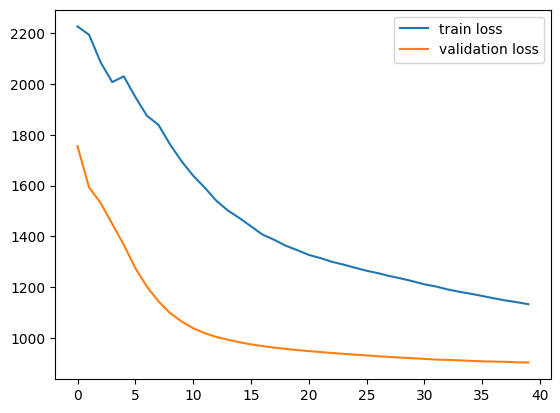

In [29]:
num_epochs = 40
batch_size = 256
model.train()
train_loss = []
val_losses = []
for epoch in range(num_epochs):   
    model.train()
    val_predictions_list = []
    for i in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        indices = range(i, min(i+batch_size, len(X_train)))
        X_batch = X_train[indices].to(device)
        out = model(X_batch)
        loss = criterion(out, y_train[indices].to(device))        
        loss.backward()
        optimizer.step()
    model.eval()
    val_out = model(X_val.to(device))
    val_loss = criterion(val_out, y_val.to(device)).item()
    val_r2 = r2_score(y_val.cpu().numpy(),val_out.cpu().detach().numpy())
    train_loss.append(loss.item())
    print(f'Epoch {epoch}, train loss: {loss.item()} , val_loss: {val_loss}, val_r2 {val_r2}')
    val_losses.append(val_loss)
# plot the loss on the training    
plt.plot(train_loss, label='train loss')
plt.plot(val_losses, label='validation loss')
plt.legend()
plt.show()

In [30]:
from sklearn.metrics import r2_score

Test loss: 282.96087646484375
RMSE on test set: 16.82144097468596
 R2 score: 0.8237956195146802


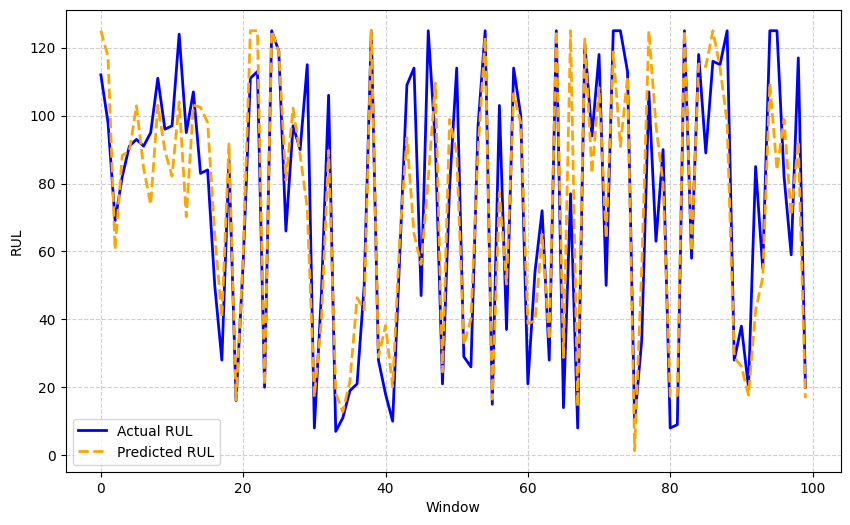

In [31]:
model.eval()    
test_predictions = model(X_test.to(device))
# clip test predictions between 0 and 125
test_predictions = torch.clamp(test_predictions, 0, 125)

test_loss = criterion(test_predictions, y_test.to(device)).item()
test_predictions = test_predictions.cpu().detach().numpy().flatten()
test_r2 = r2_score(y_test,test_predictions)

print(f'Test loss: {test_loss}')
print(f"RMSE on test set: {test_loss**(0.5)}")
print(f' R2 score: {test_r2}')
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual RUL', color='blue', linewidth=2)
plt.plot(test_predictions, label='Predicted RUL', color='orange', linestyle='--', linewidth=2)
plt.xlabel('Window')
plt.ylabel('RUL')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()  # Inline visualization during the loop